# **Project Goal**

# *Quantitatively understand relation air quality (AQI & pollutant concentrations) and meteorological drivers across different Indian cities for 2019–2025. Test hypotheses about how weather (wind, temperature, humidity, rainfall) influences pollution levels and seasonal peaks. Predict pollutant (PM 2.5, PM 10) concentrations for 7 days.*

# **Data sources : Dwaraka Station**

```
 **AQI , pollutant**: daily data from the CPCB NAMP

 **metereological data** : NASA

```

# **Data download**

Data downloaded from

CPCB : https://airquality.cpcb.gov.in/ccr/#/caaqm-dashboard-all/caaqm-landing/caaqm-data-repository

NASA : https://power.larc.nasa.gov/data-access-viewer/

#  **Preprocessing**

In [19]:
import pandas as pd

"""
Preprocessing
1. Merging CPCB and NASA data
2. Flagging NaN values
3. Imputing missing values using forward fill

"""

# CPCB Daily
daily = pd.read_csv("CPCB_NSIT_Dwarka_DailyMeans_2019_2024.csv")
daily["Date"] = pd.to_datetime(daily["Date"], errors="coerce")
daily["Location"] = "Dwarka"

# NASA POWER Daily
nasa = pd.read_csv("POWER_Point_Daily_20190101_20250919_028d64N_077d22E_LST.csv", skiprows=11)

nasa["Date"] = pd.to_datetime(nasa["YEAR"].astype(str) + nasa["DOY"].astype(str),format="%Y%j")

nasa = nasa.replace(-999, pd.NA)

nasa["Location"] = "Dwarka"

# Merge CPCB Daily and NASA
merged = pd.merge(daily,nasa,on=["Date", "Location"],how="outer")
merged = merged.sort_values("Date").reset_index(drop=True)

for col in merged.columns:
    if col not in ["Date", "Location"]:
        merged[f"{col}_missing"] = merged[col].isna().astype(int)

merged_imputed = merged.copy()
merged_imputed.fillna(method="ffill", inplace=True)
merged_imputed.fillna(merged_imputed.mean(numeric_only=True), inplace=True)

merged.to_csv("Merged_CPCB_NASA_Dwarka_Flagged.csv", index=False)
merged_imputed.to_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv", index=False)

print()
print(" completed cleand, merging - CPCB and NASA ")

/tmp/ipython-input-1638825302.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_imputed.fillna(method="ffill", inplace=True)
/tmp/ipython-input-1638825302.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_imputed.fillna(method="ffill", inplace=True)



 completed cleand, merging - CPCB and NASA 


In [20]:
daily.columns

Index(['Date', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
       'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
       'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)',
       'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)',
       'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)',
       'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Location'],
      dtype='object')

In [21]:
nasa.columns

Index(['YEAR', 'DOY', 'RH2M', 'T2M', 'PRECTOTCORR', 'Date', 'Location'], dtype='object')

#**Exploratory Data Analysis (EDA)**

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

# Ensure Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Set Date as index
# df.set_index('Date', inplace=True)

# --- Step 2: Define Pollutants ---
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)','CO (mg/m³)',
       'Ozone (µg/m³)']

# Convert pollutants to numeric (coerce errors will replace bad values with NaN)
for p in pollutants:
    if p in df.columns:
        df[p] = pd.to_numeric(df[p], errors='coerce')


# Daily Trends

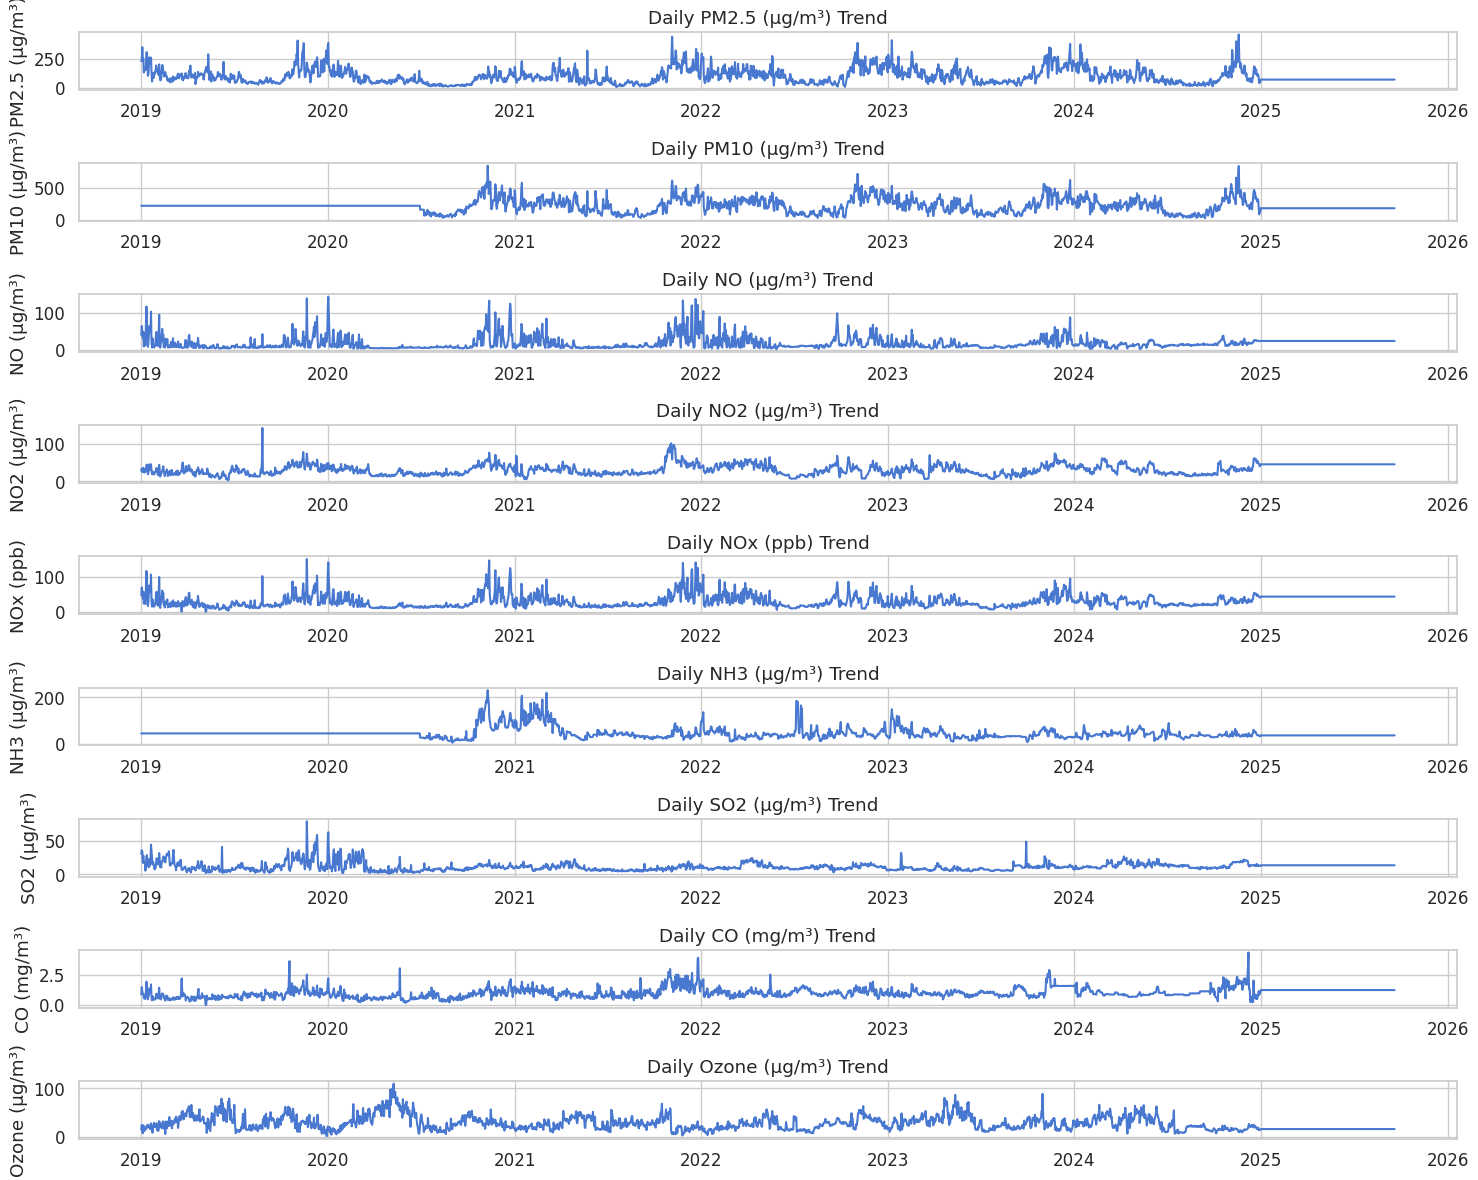

In [59]:
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

plt.figure(figsize=(15,12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(len(pollutants), 1, i)
    sns.lineplot(data=df, x='Date', y=pollutant)
    plt.title(f'Daily {pollutant} Trend')
    plt.xlabel('')
plt.tight_layout()
plt.savefig("plots/daily_trends.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()



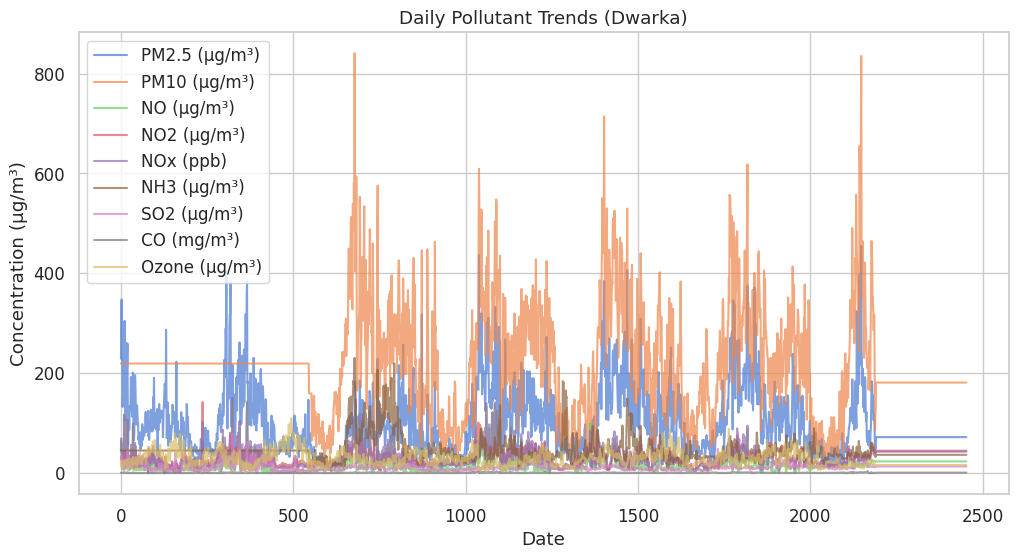

In [60]:
plt.figure(figsize=(12,6))
for p in pollutants:
    if p in df.columns:
        plt.plot(df.index, df[p], label=p, alpha=0.7)

plt.title("Daily Pollutant Trends (Dwarka)")
plt.xlabel("Date")
plt.ylabel("Concentration (µg/m³)")
plt.legend()
plt.grid(True)
plt.savefig("plots/daily_trends1.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# Monthly Trends

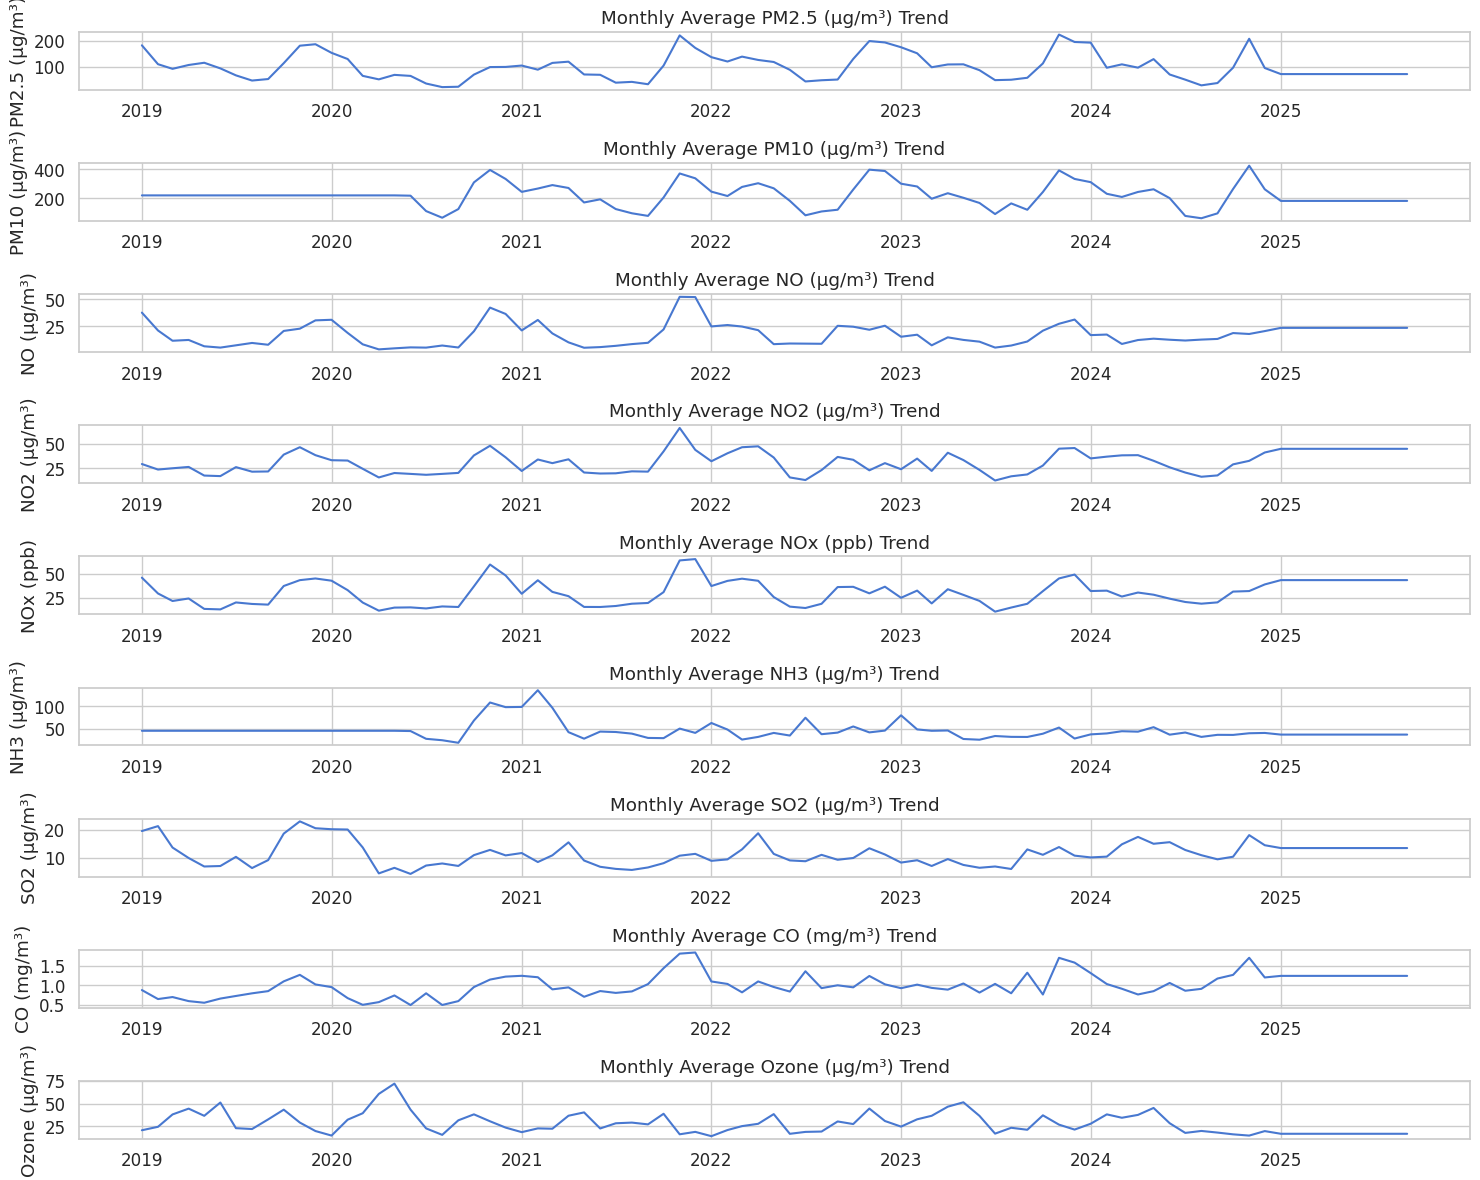

In [61]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_df = df.groupby('Month')[pollutants].mean().reset_index()
monthly_df['Month'] = monthly_df['Month'].dt.to_timestamp()

plt.figure(figsize=(15,12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(len(pollutants), 1, i)
    sns.lineplot(data=monthly_df, x='Month', y=pollutant)
    plt.title(f'Monthly Average {pollutant} Trend')
    plt.xlabel('')
plt.tight_layout()
plt.savefig("plots/monthly_trends.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


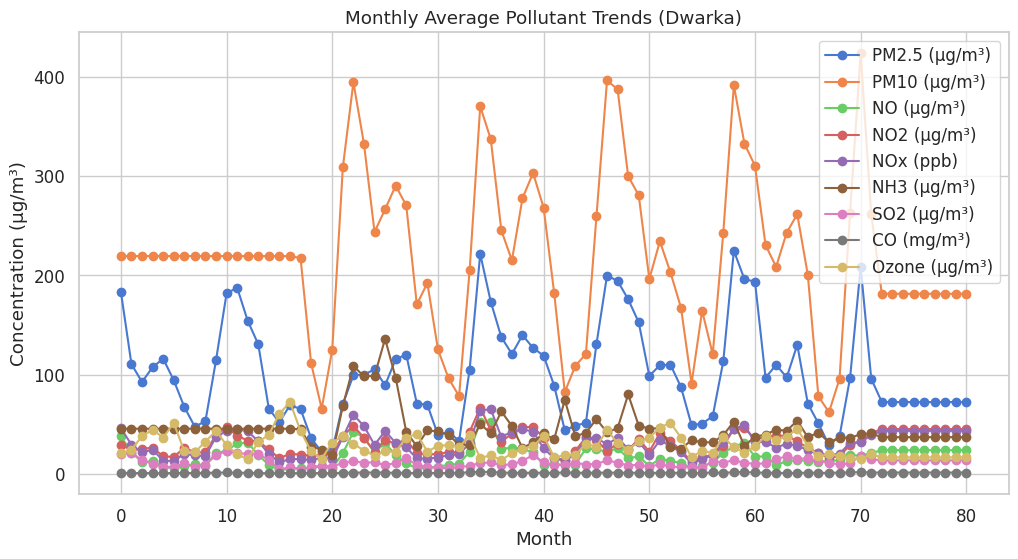

In [63]:
# monthly = df.resample('M').mean(numeric_only=True)
df['Month'] = df['Date'].dt.to_period('M')
monthly_df = df.groupby('Month')[pollutants].mean().reset_index()
monthly_df['Month'] = monthly_df['Month'].dt.to_timestamp()

plt.figure(figsize=(12,6))
for p in pollutants:
    if p in monthly_df.columns:
        plt.plot(monthly_df.index, monthly_df[p], label=p, marker='o')

plt.title("Monthly Average Pollutant Trends (Dwarka)")
plt.xlabel("Month")
plt.ylabel("Concentration (µg/m³)")
plt.legend()
plt.grid(True)

plt.savefig("plots/monthly_trends_1.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# AQI Trends Daily and Monthly

In [65]:
import pandas as pd

AQI_df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

# Indian AQI Breakpoints (CPCB standard)
# Format: (Low, High, Index Low, Index High)
breakpoints = {
    "PM2.5 (µg/m³)": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
              (91, 120, 201, 300), (121, 250, 301, 400), (251, 9999, 401, 500)],

    "PM10 (µg/m³)": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 9999, 401, 500)],

    "NO2 (µg/m³)": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 9999, 401, 500)],

    "SO2 (µg/m³)": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
            (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 9999, 401, 500)],

    "CO (mg/m³)": [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200),
           (10.1, 17, 201, 300), (17.1, 34, 301, 400), (34.1, 9999, 401, 500)],

    "Ozone (µg/m³)": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
           (169, 208, 201, 300), (209, 748, 301, 400), (749, 9999, 401, 500)]
}

def calculate_subindex(concentration, pollutant):
    for (low, high, idx_low, idx_high) in breakpoints[pollutant]:
        if low <= concentration <= high:
            return ((idx_high - idx_low) / (high - low)) * (concentration - low) + idx_low
    return None

sub_indices = pd.DataFrame()

for pollutant in breakpoints.keys():
    if pollutant in AQI_df.columns:
        sub_indices[pollutant] = AQI_df[pollutant].apply(lambda x: calculate_subindex(x, pollutant))

AQI_df["AQI"] = sub_indices.max(axis=1)

# --- AQI Category ---
def get_aqi_category(aqi):
    if pd.isna(aqi): return "NA"
    elif aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    elif aqi <= 400: return "Very Poor"
    else: return "Severe"

AQI_df["AQI_Category"] = AQI_df["AQI"].apply(get_aqi_category)

# --- Save output ---
output_file = "AQI_Calculated.csv"
AQI_df.to_csv(output_file, index=False)


In [66]:
AQI_df.head(2)

Date  PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
0  2019-01-01     229.566667    219.586065   40.586667    27.913333   
1  2019-01-02     248.593333    219.586065   64.580000    34.106667   

   NOx (ppb)  NH3 (µg/m³)  SO2 (µg/m³)  CO (mg/m³)  Ozone (µg/m³)  ...  \
0      47.32    45.436767    30.533333    0.873333      15.496667  ...   
1      69.81    45.436767    35.793333    1.486667      25.093333  ...   

   SR (W/mt2)_missing  BP (mmHg)_missing  VWS (m/s)_missing  YEAR_missing  \
0                   0                  1                  0             0   
1                   0                  1                  0             0   

   DOY_missing  RH2M_missing  T2M_missing  PRECTOTCORR_missing         AQI  \
0            0             0            0                    0  384.318605   
1            0             0            0                    0  398.920465   

   AQI_Category  
0     Very Poor  
1     Very Poor  

[2 rows x 62 columns]

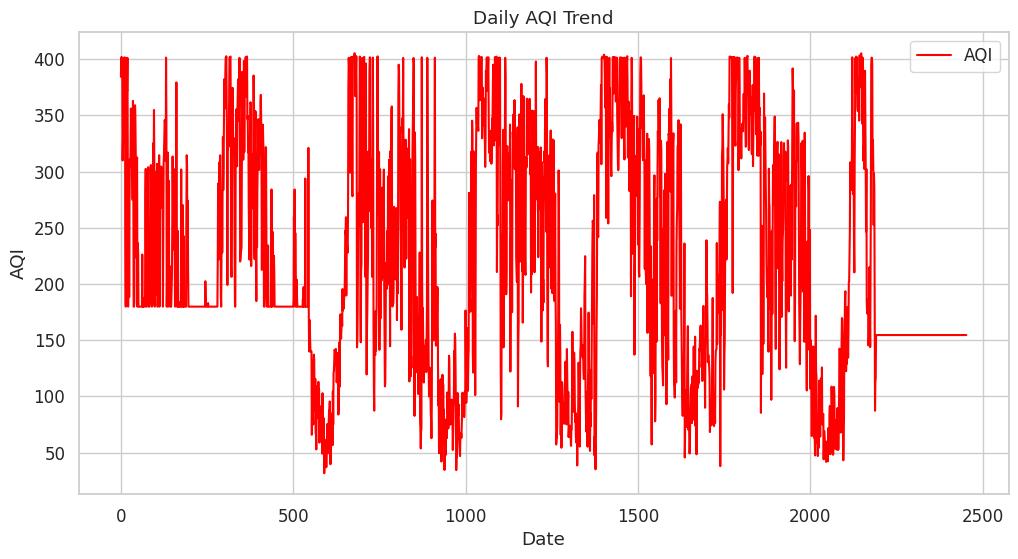

In [67]:
# AQI Trends
if 'AQI' in AQI_df.columns:
    plt.figure(figsize=(12,6))
    plt.plot(df.index, AQI_df['AQI'], label="AQI", color="red")
    plt.title("Daily AQI Trend")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/Daily_AQI_trends.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [68]:
AQI_df['AQI'].unique()

array([384.31860465, 398.92046512, 401.982857  , ..., 112.87557047,
       115.88765101, 154.51536913])

In [69]:
AQI_df

Date  PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
0     2019-01-01     229.566667    219.586065   40.586667    27.913333   
1     2019-01-02     248.593333    219.586065   64.580000    34.106667   
2     2019-01-03     347.776667    219.586065   49.273333    24.933333   
3     2019-01-04     230.426667    219.586065   31.156667    24.220000   
4     2019-01-05     252.943333    219.586065   48.146667    35.833333   
...          ...            ...           ...         ...          ...   
2449  2025-09-15      72.306667    181.543333   23.730000    45.070000   
2450  2025-09-16      72.306667    181.543333   23.730000    45.070000   
2451  2025-09-17      72.306667    181.543333   23.730000    45.070000   
2452  2025-09-18      72.306667    181.543333   23.730000    45.070000   
2453  2025-09-19      72.306667    181.543333   23.730000    45.070000   

      NOx (ppb)  NH3 (µg/m³)  SO2 (µg/m³)  CO (mg/m³)  Ozone (µg/m³)  ...  \
0     47.320000    45.436767    30.533333    0.873333      15.496667  ...   
1     69.810000    45.436767    35.793333    1.486667      25.093333  ...   
2     52.593333    45.436767    34.213333    1.093333      12.036667  ...   
3     37.806667    45.436767    17.450000    0.976667       7.830000  ...   
4     57.576667    45.436767    27.623333    0.933333      24.003333  ...   
...         ...          ...          ...         ...            ...  ...   
2449  43.256667    36.900000    13.490000    1.243333      16.500000  ...   
2450  43.256667    36.900000    13.490000    1.243333      16.500000  ...   
2451  43.256667    36.900000    13.490000    1.243333      16.500000  ...   
2452  43.256667    36.900000    13.490000    1.243333      16.500000  ...   
2453  43.256667    36.900000    13.490000    1.243333      16.500000  ...   

      SR (W/mt2)_missing  BP (mmHg)_missing  VWS (m/s)_missing  YEAR_missing  \
0                      0                  1                  0             0   
1                      0                  1                  0             0   
2                      0                  1                  0             0   
3                      0                  1                  0             0   
4                      0                  1                  0             0   
...                  ...                ...                ...           ...   
2449                   1                  1                  1             0   
2450                   1                  1                  1             0   
2451                   1                  1                  1             0   
2452                   1                  1                  1             0   
2453                   1                  1                  1             0   

      DOY_missing  RH2M_missing  T2M_missing  PRECTOTCORR_missing         AQI  \
0               0             0            0                    0  384.318605   
1               0             0            0                    0  398.920465   
2               0             0            0                    0  401.982857   
3               0             0            0                    0  384.978605   
4               0             0            0                    0  401.019736   
...           ...           ...          ...                  ...         ...   
2449            0             0            0                    0  154.515369   
2450            0             0            0                    0  154.515369   
2451            0             1            1                    1  154.515369   
2452            0             1            1                    1  154.515369   
2453            0             1            1                    1  154.515369   

      AQI_Category  
0        Very Poor  
1        Very Poor  
2           Severe  
3        Very Poor  
4           Severe  
...            ...  
2449      Moderate  
2450      Moderate  
2451      Moderate  
2452      Moderate  
2453      Moderate  

[2454 rows 

/tmp/ipython-input-3348153319.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = AQI_df['AQI'].resample('M').mean()


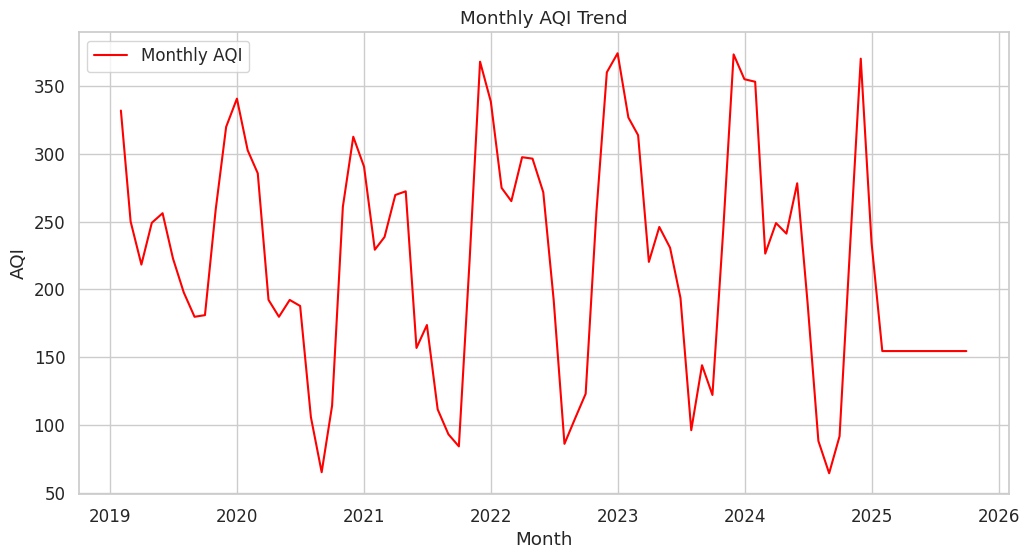

In [70]:
import pandas as pd
import matplotlib.pyplot as plt


AQI_df['Date'] = pd.to_datetime(AQI_df['Date'])
AQI_df.set_index('Date', inplace=True)

df_monthly = AQI_df['AQI'].resample('M').mean()

if 'AQI' in AQI_df.columns:
  plt.figure(figsize=(12, 6))
  plt.plot(df_monthly.index, df_monthly, label='Monthly AQI', color='red')
  plt.title('Monthly AQI Trend')
  plt.xlabel('Month')
  plt.ylabel('AQI')
  plt.legend()
  plt.grid(True)
  plt.savefig("plots/Monthly_AQI_trends.png", dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()

# Seasonal decomposition; identify peaks (festival/fireworks, crop burning, lockdown 2020 anomalies).

/tmp/ipython-input-966295137.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


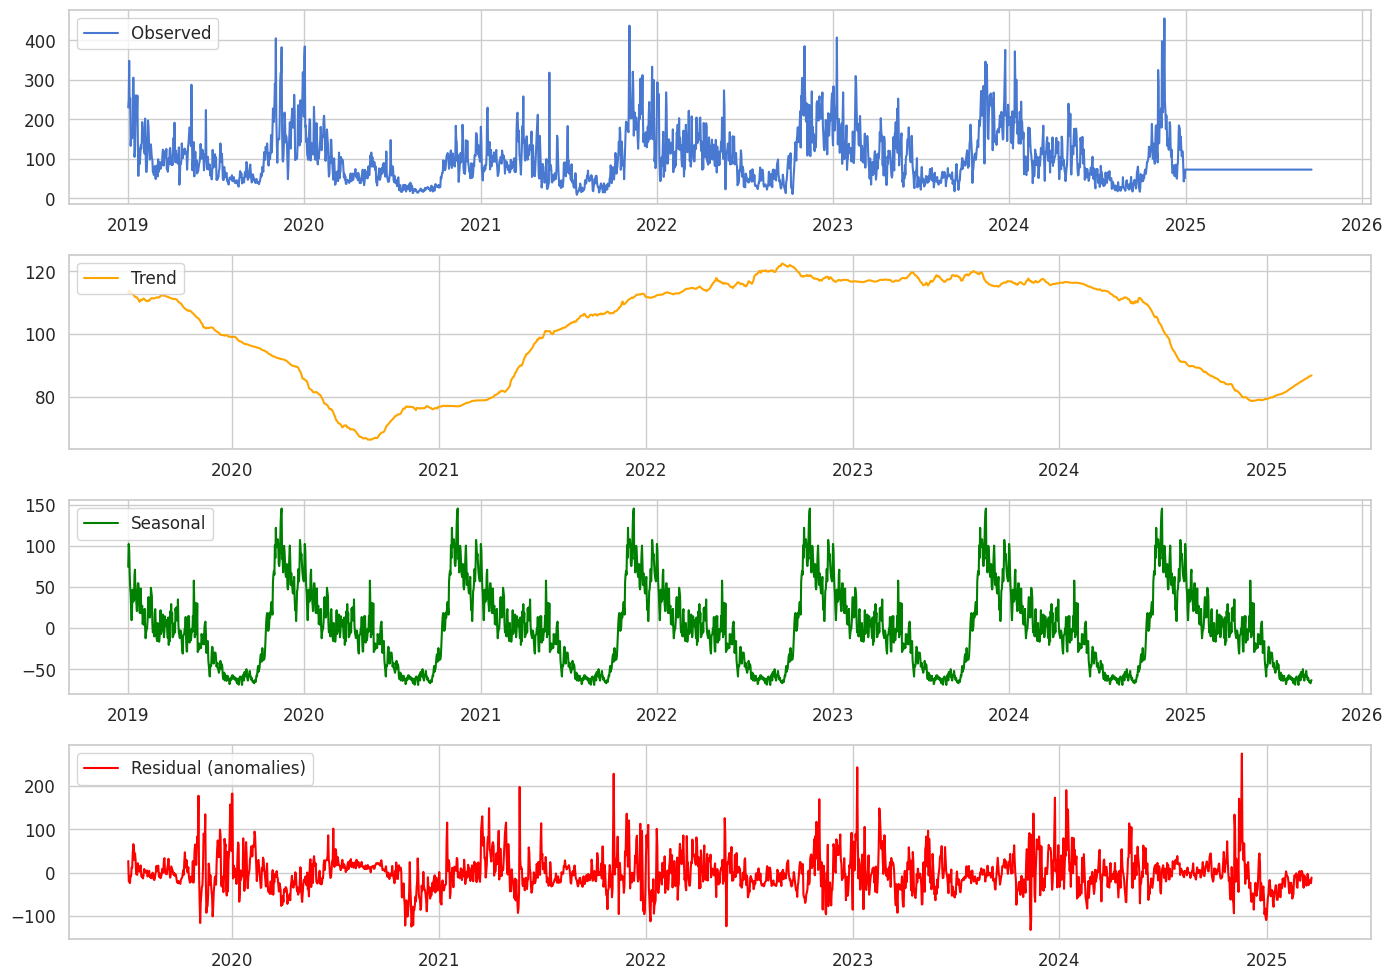

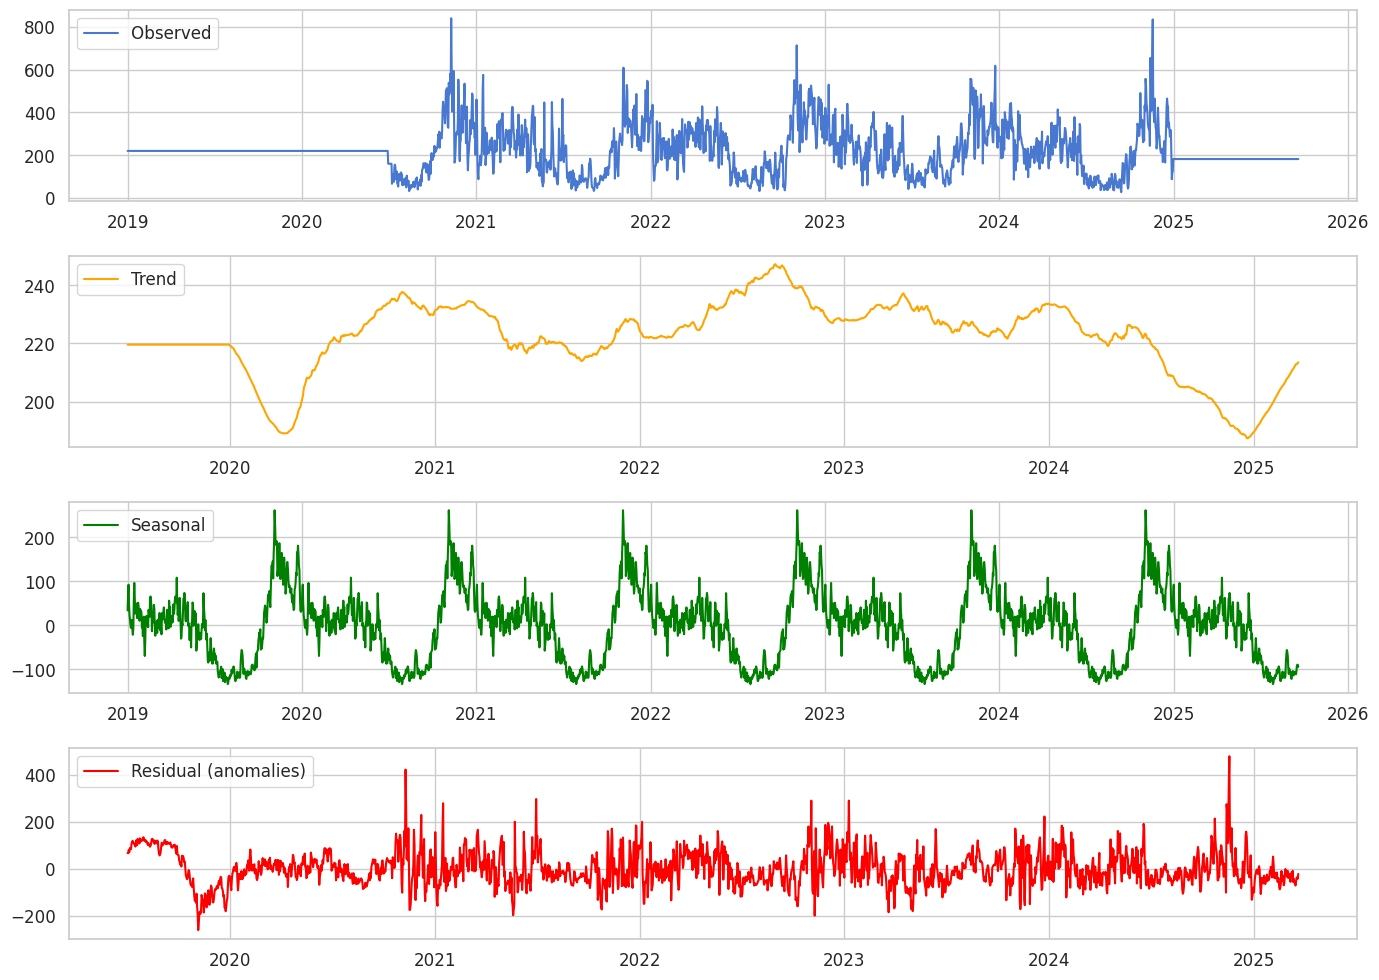

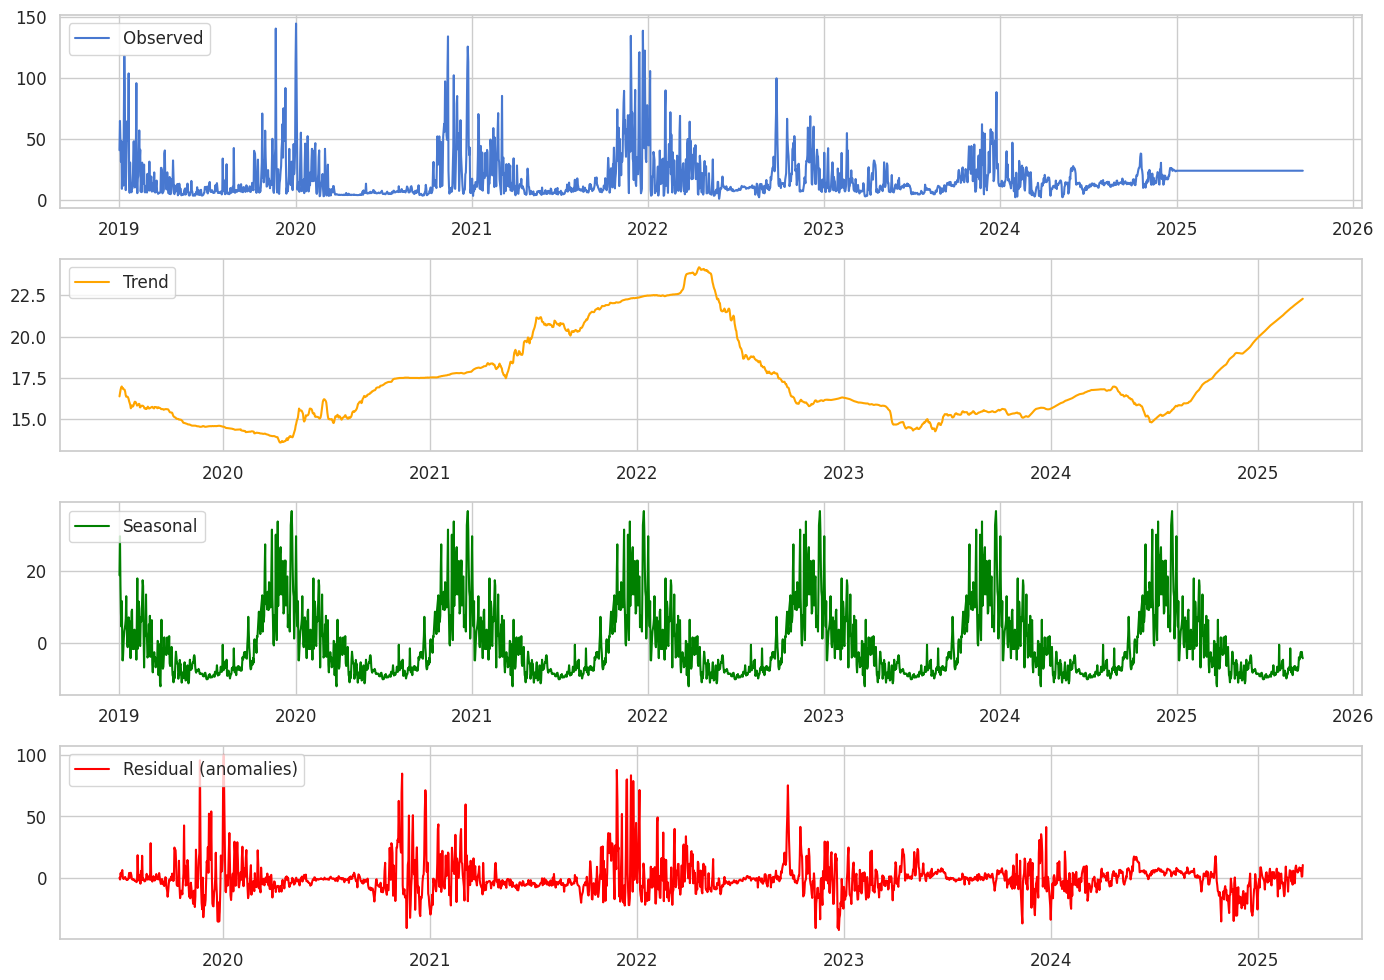

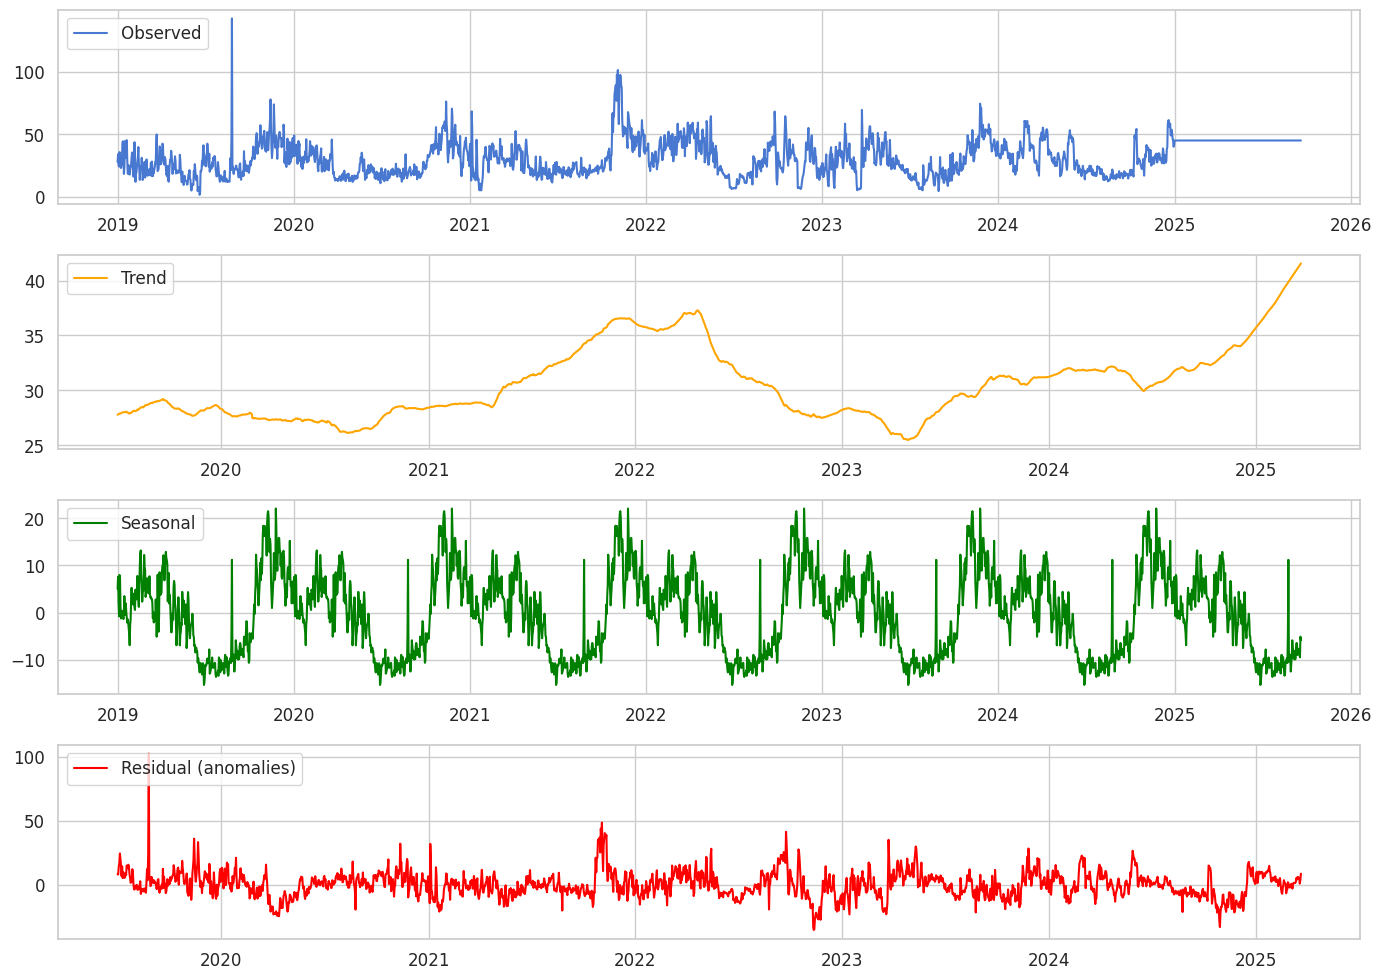

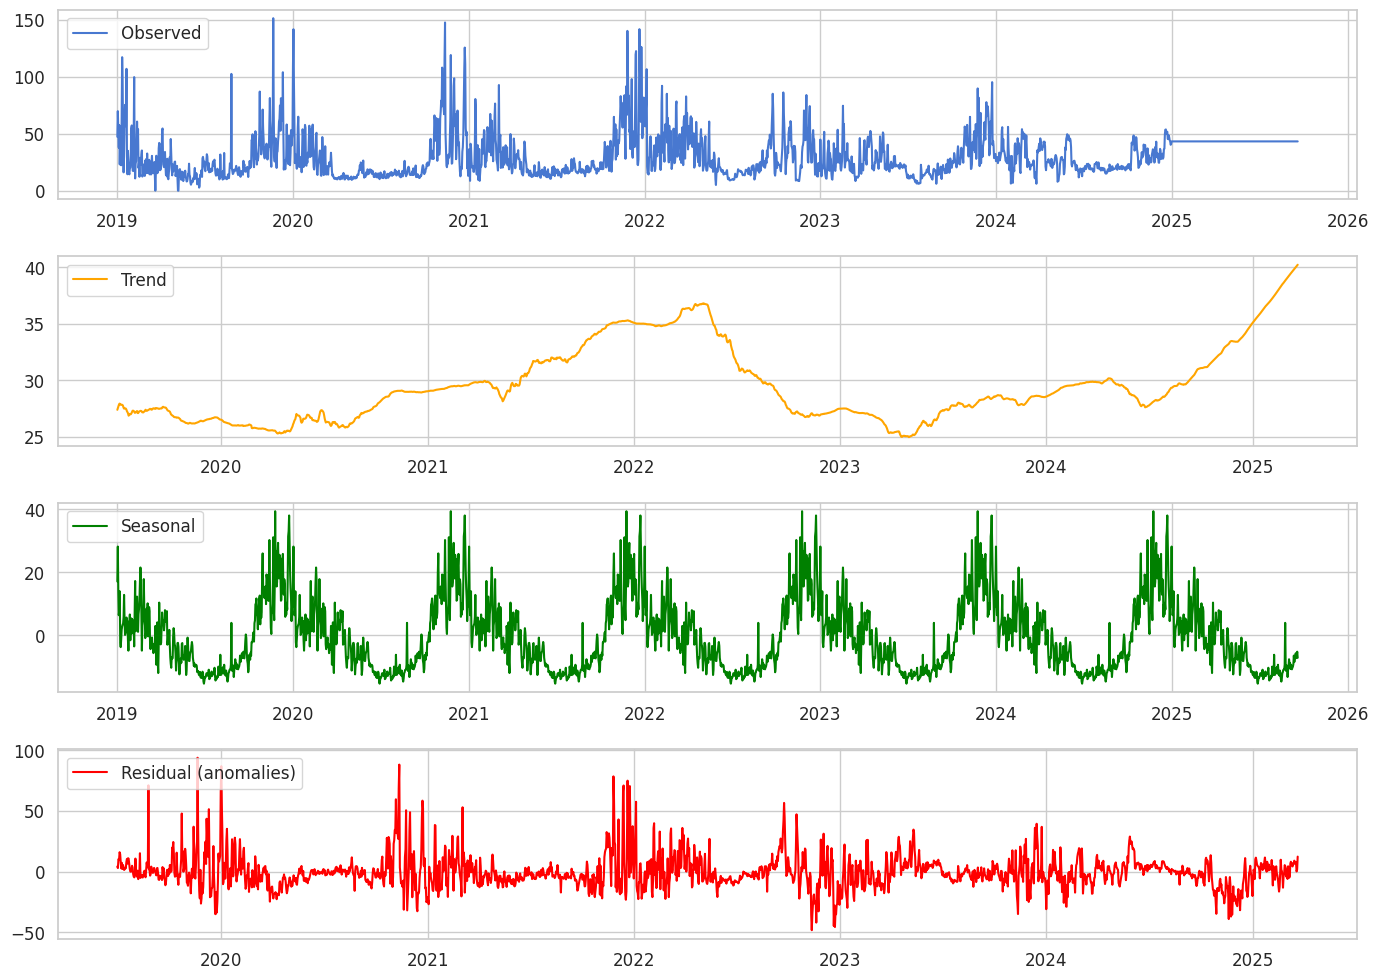

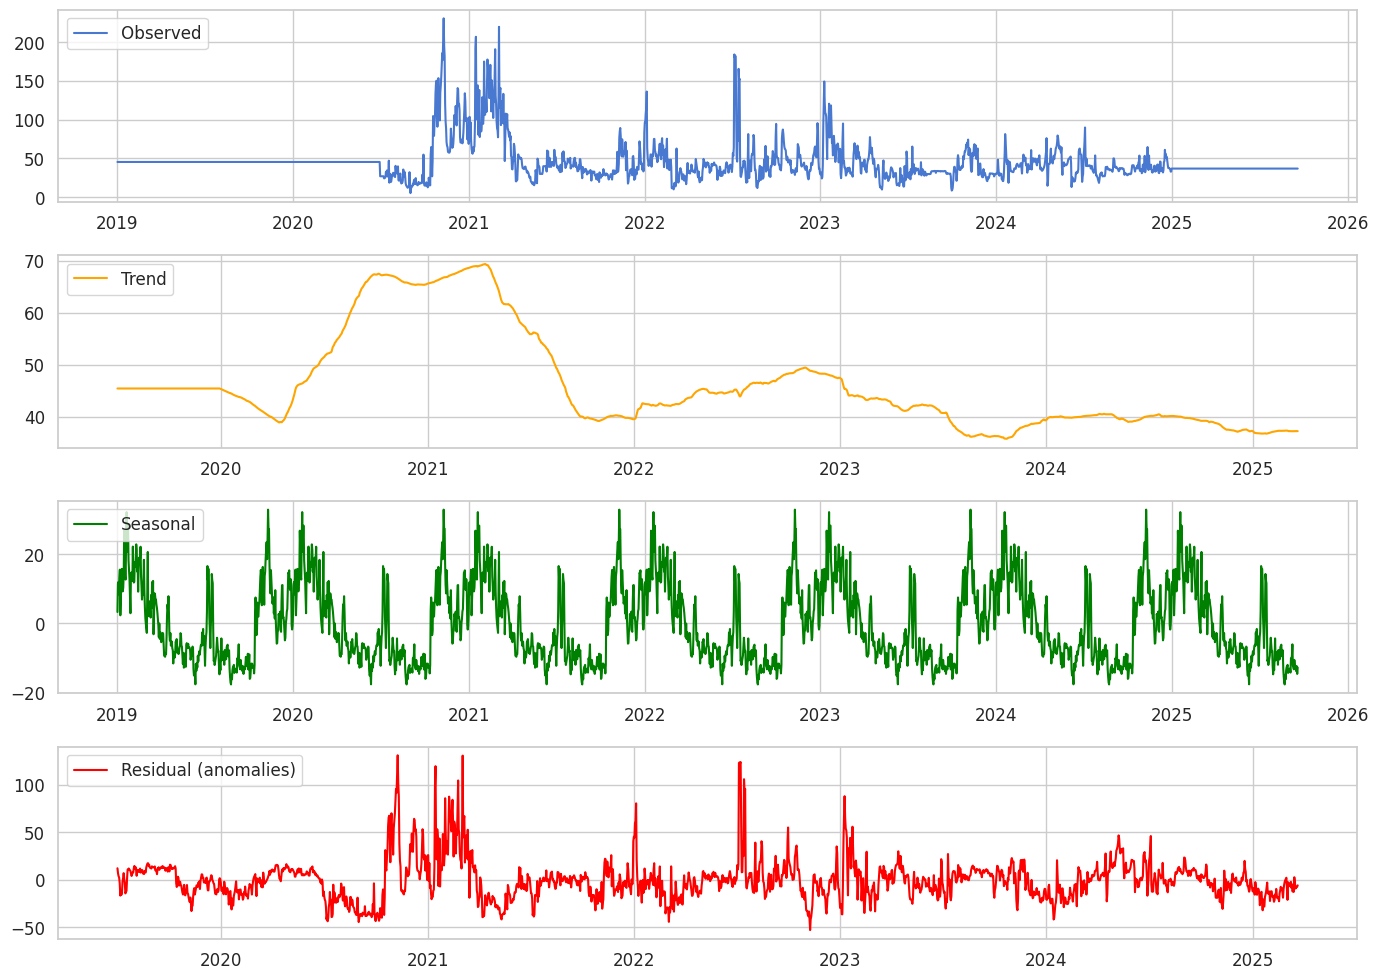

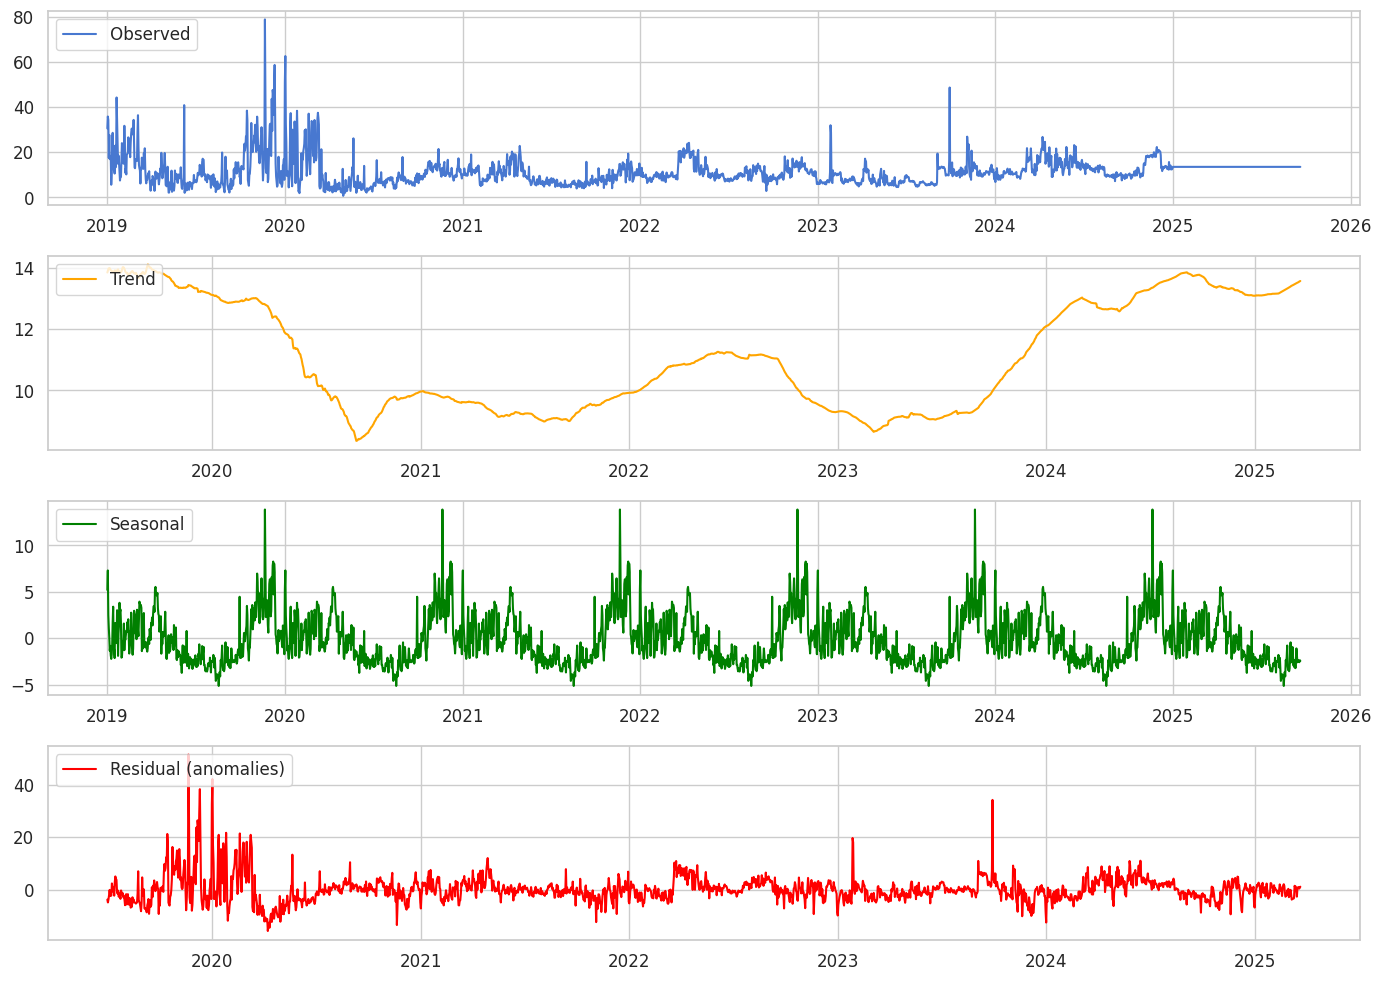

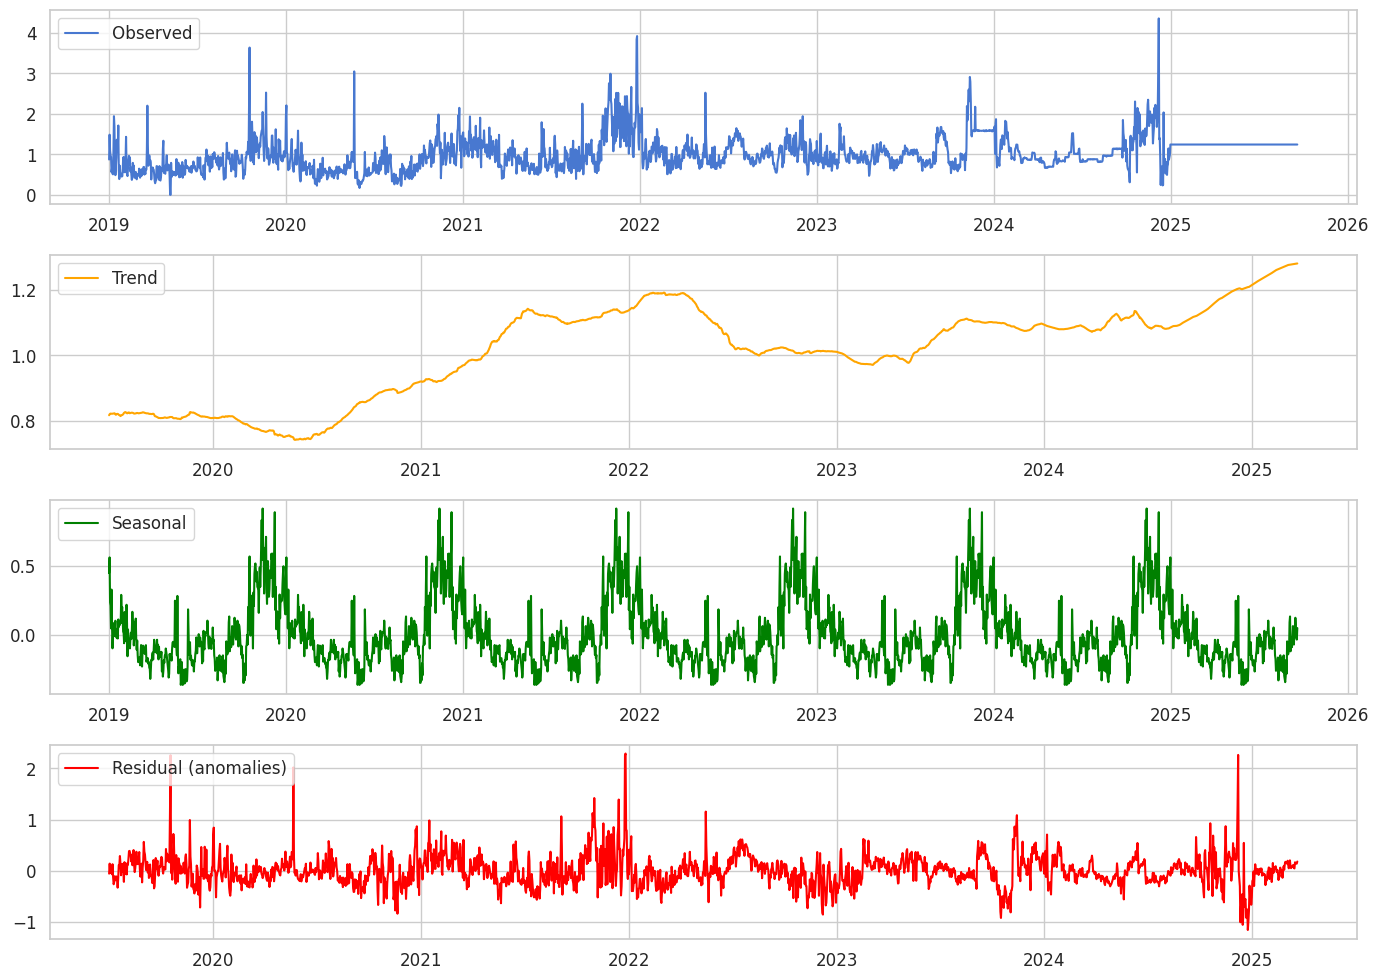

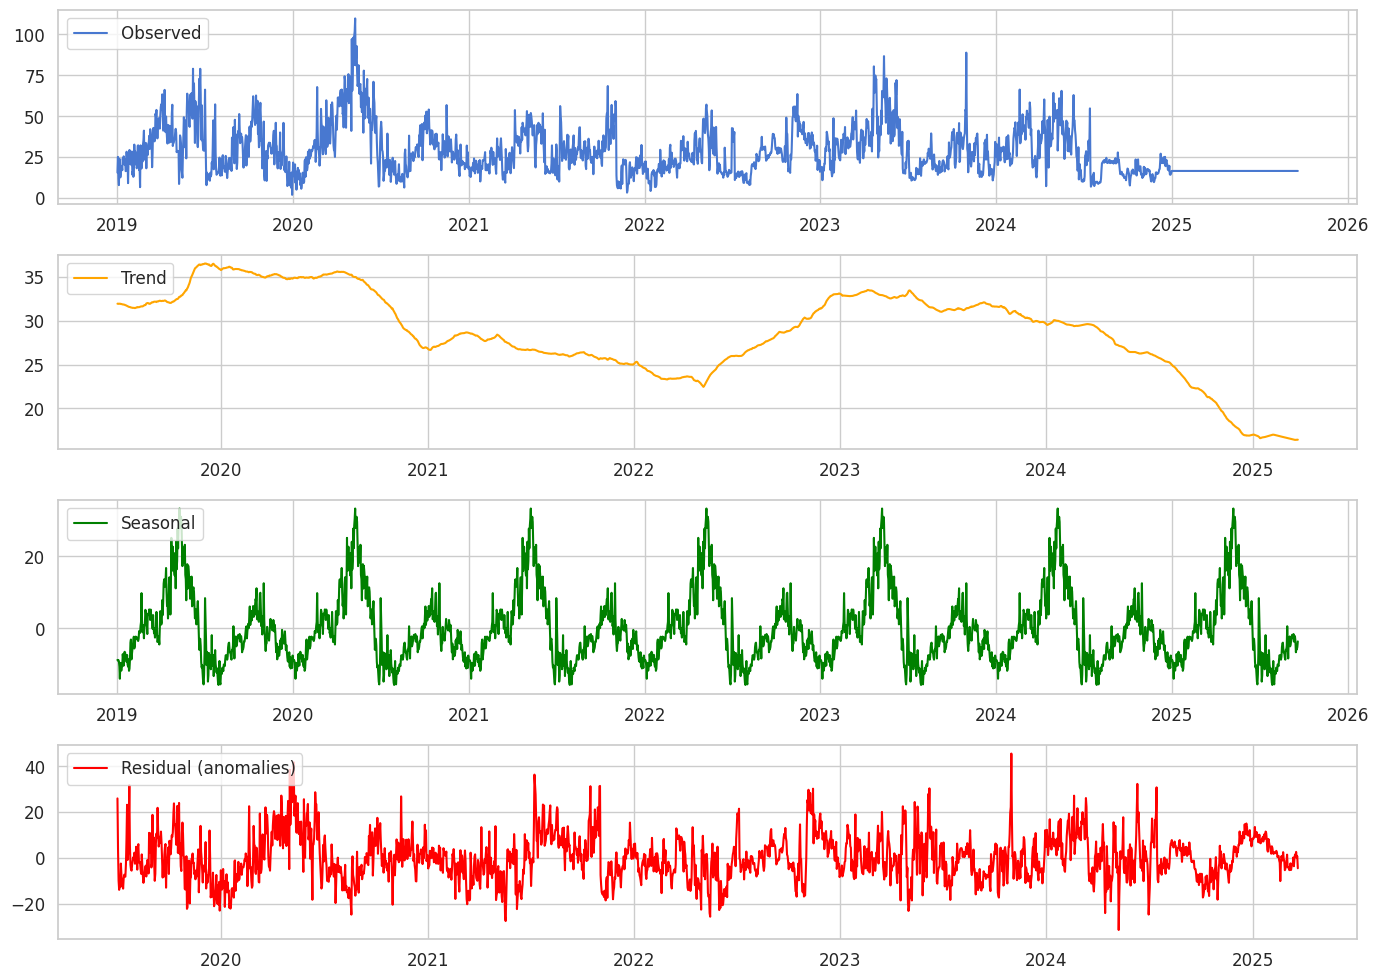

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

for pollutant in pollutants:

  # # pollutant for decomposition ---
  # pollutant = 'PM2.5 (µg/m³)'

  ts = df.set_index('Date')[pollutant].asfreq('D')
  ts = ts.fillna(method='ffill')

  # Seasonal decomposition ---
  result = seasonal_decompose(ts, model='additive', period=365)

  plt.figure(figsize=(14,10))
  plt.subplot(411)
  plt.plot(result.observed, label='Observed')
  plt.legend(loc='upper left')
  plt.subplot(412)
  plt.plot(result.trend, label='Trend', color='orange')
  plt.legend(loc='upper left')
  plt.subplot(413)
  plt.plot(result.seasonal, label='Seasonal', color='green')
  plt.legend(loc='upper left')
  plt.subplot(414)
  plt.plot(result.resid, label='Residual (anomalies)', color='red')
  plt.legend(loc='upper left')
  plt.tight_layout()
  name = pollutant.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("µ", "u")
  plt.savefig(f"plots/{name}_seasonal_decompose.png", dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()

# Anomalies

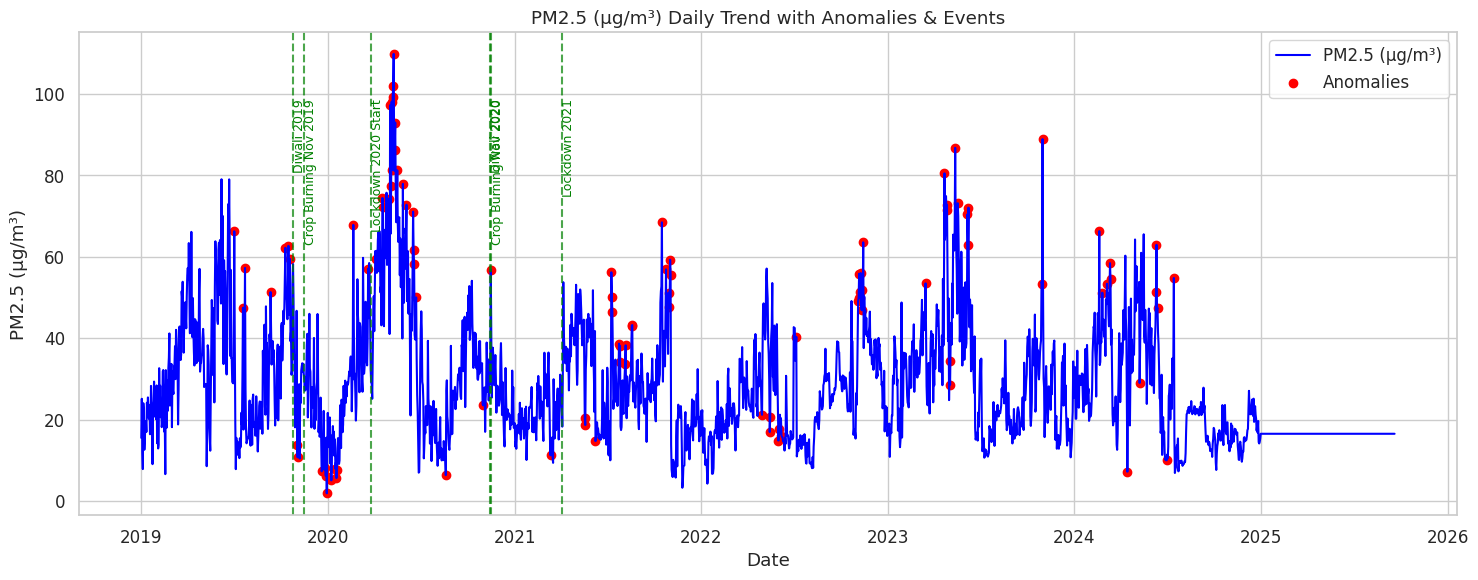

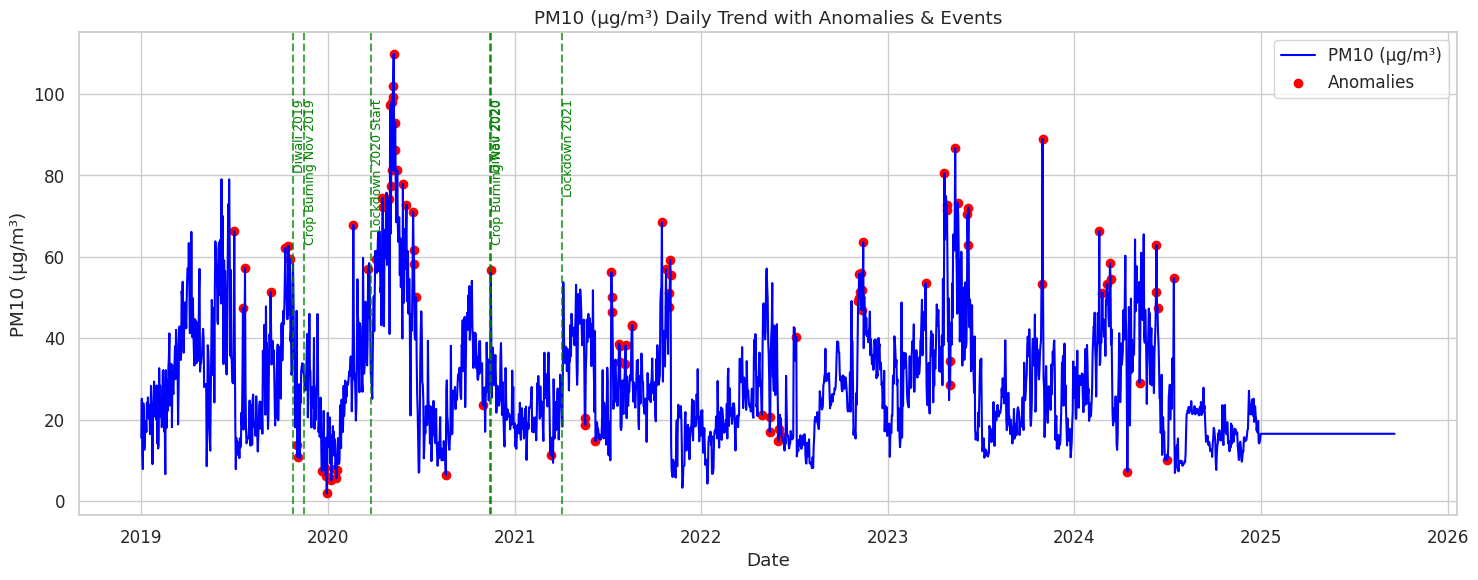

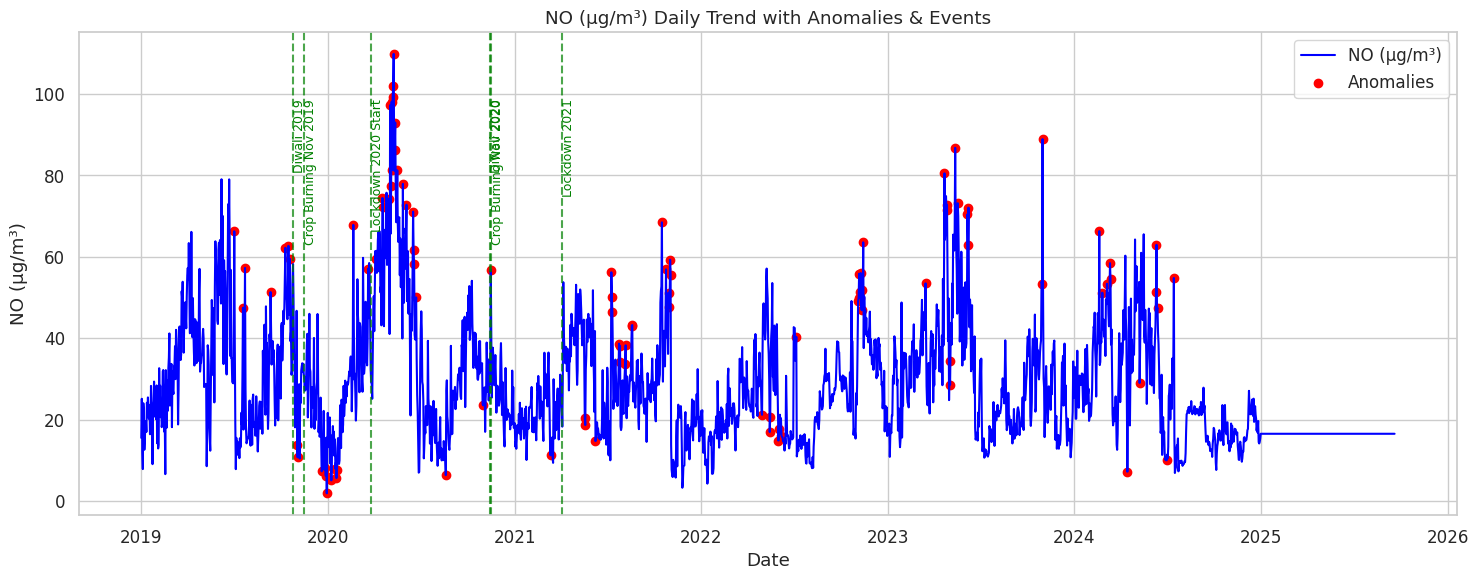

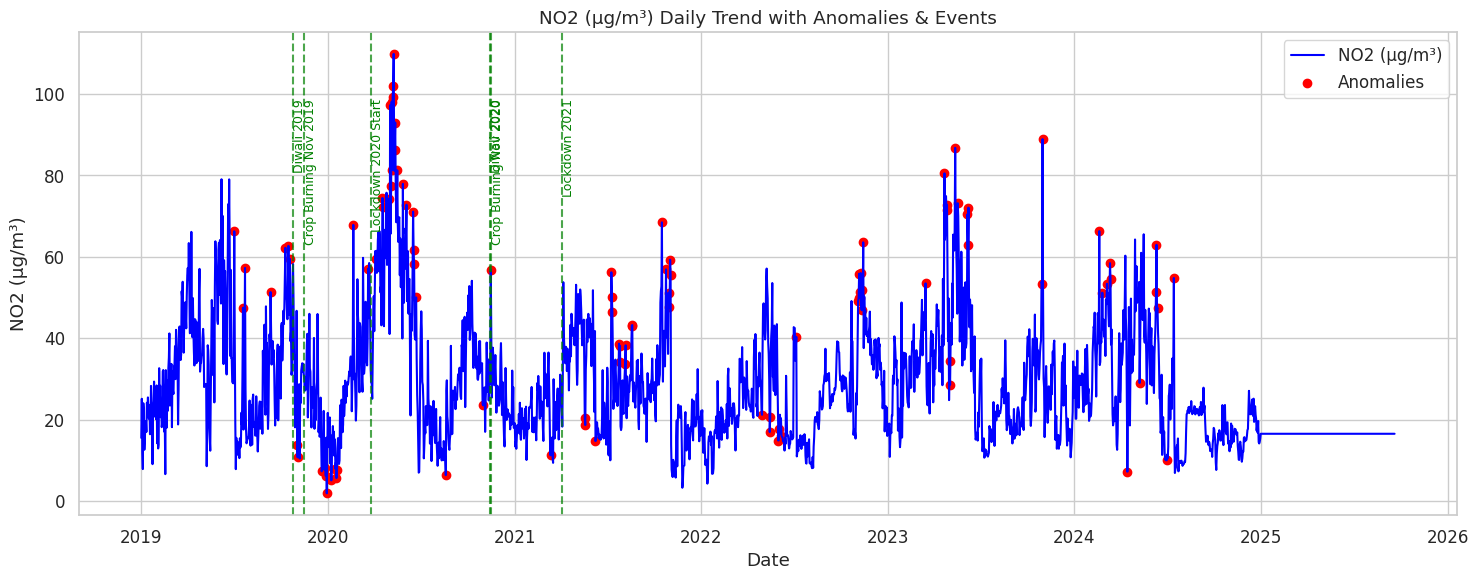

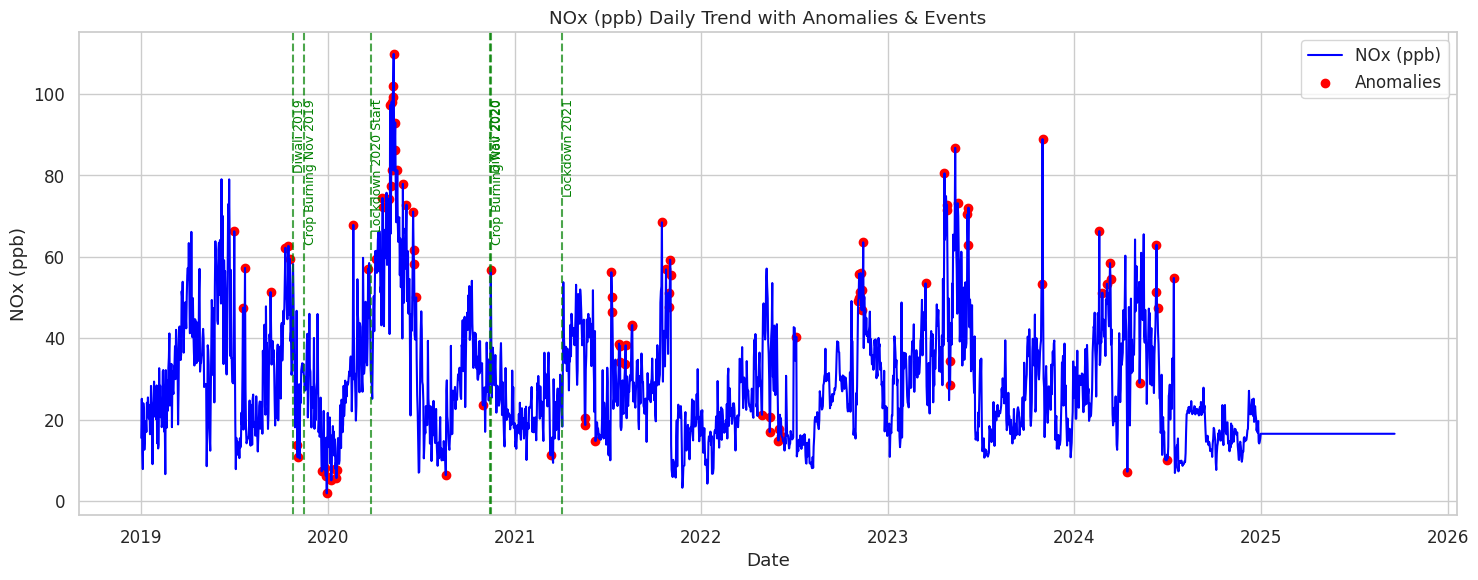

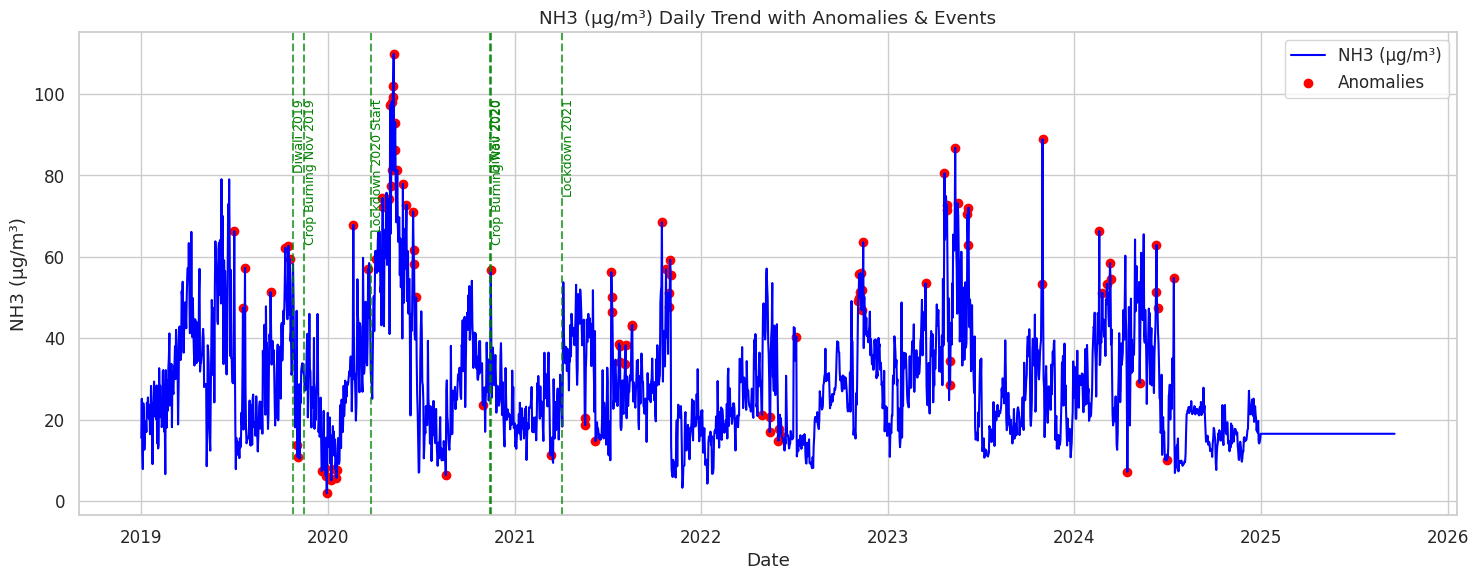

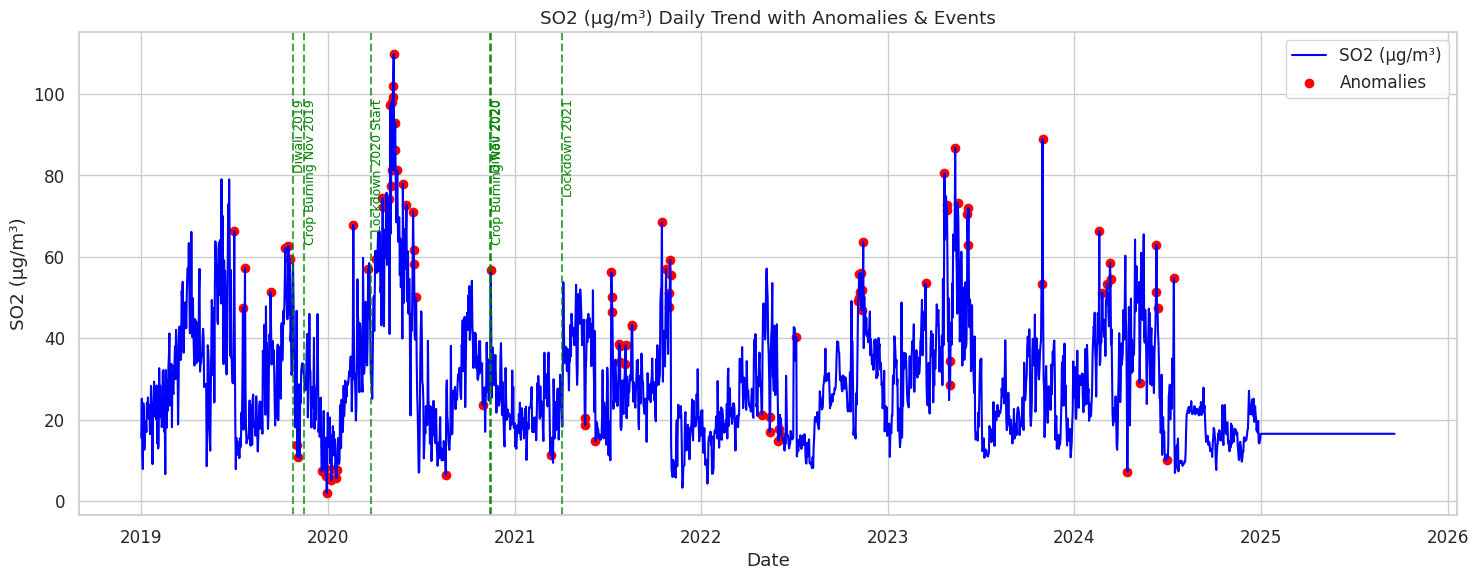

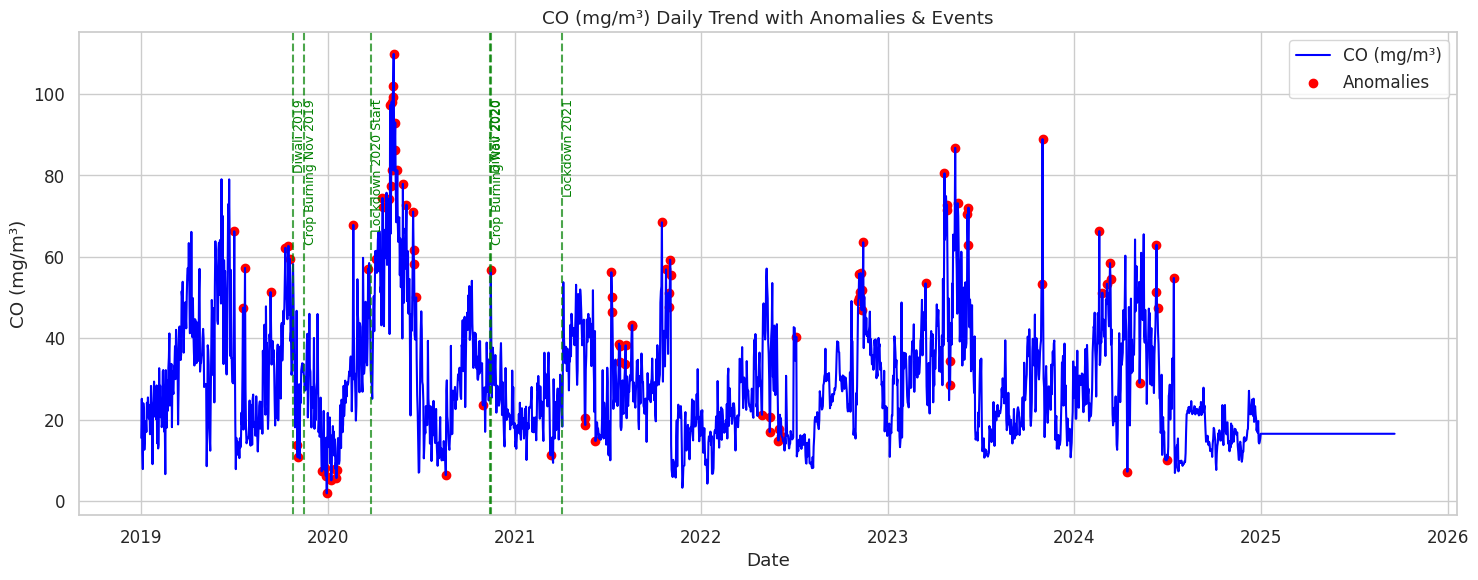

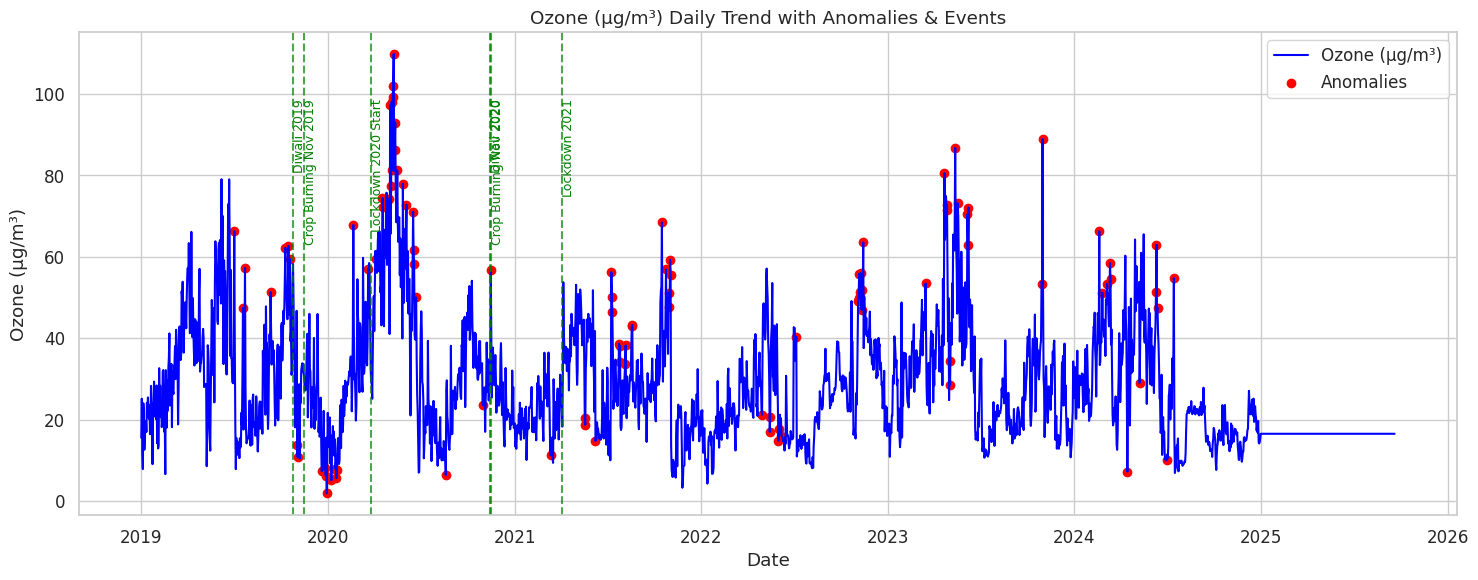

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

for pollutant in pollutants:

  # Highlight anomalies (residuals > 2 std dev)
  residual = result.resid
  threshold = 2 * residual.std()
  anomalies = residual[(residual > threshold) | (residual < -threshold)]

  events = {
    "Diwali 2019": pd.Timestamp('2019-10-25'),
    "Crop Burning Nov 2019": pd.Timestamp('2019-11-15'),
    "Lockdown 2020 Start": pd.Timestamp('2020-03-25'),
    "Diwali 2020": pd.Timestamp('2020-11-14'),
    "Crop Burning Nov 2020": pd.Timestamp('2020-11-15'),
    "Lockdown 2021": pd.Timestamp('2021-04-04')}


  plt.figure(figsize=(15,6))
  plt.plot(ts, label=pollutant, color='blue')
  plt.scatter(anomalies.index, ts[anomalies.index], color='red', label='Anomalies')

  for event, date in events.items():
      if date in ts.index:
          plt.axvline(date, color='green', linestyle='--', alpha=0.7)
          plt.text(date, ts.max()*0.9, event, rotation=90, verticalalignment='top', fontsize=9, color='green')

  plt.title(f'{pollutant} Daily Trend with Anomalies & Events')
  plt.xlabel('Date')
  plt.ylabel(f'{pollutant}')
  plt.legend()
  plt.tight_layout()
  name = pollutant.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("µ", "u")
  plt.savefig(f"plots/{name}_events_anomalies.png", dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()


#Spatial comparison across cities (boxplots, heatmaps).

# Comparing between two stations Dwarak and Shadipur

In [45]:
import pandas as pd

vd1 = pd.read_csv('CPCB_NSIT_Dwarka_DailyMeans_2019_2024.csv')
vd1['station'] = 'CPCB_NSIT_Dwarka'

vd2 = pd.read_csv('CPCB_Shadipur_Delhi_Raw_data_merged_2009_2024.csv')
vd2['station'] = 'CPCB_Shadipur_Delhi'

vd1['Timestamp'] = pd.to_datetime(vd1['Date'], errors='coerce')
vd2['Timestamp'] = pd.to_datetime(vd2['Timestamp'], errors='coerce')

vd1.drop(columns=['Date'], inplace=True, errors='ignore')
vd2.drop(columns=['Date'], inplace=True, errors='ignore')

common_cols = list(set(vd1.columns) & set(vd2.columns))

common_cols = ['station', 'Timestamp'] + [col for col in common_cols if col not in ['station', 'Timestamp']]

vd1_filtered = vd1[common_cols]
vd2_filtered = vd2[common_cols]

merged = pd.concat([vd1_filtered, vd2_filtered], ignore_index=True)

merged = merged.sort_values(['station', 'Timestamp']).reset_index(drop=True)

for col in merged.columns:
    if col not in ['Timestamp', 'station']:
        merged[f"{col}_missing"] = merged[col].isna().astype(int)

merged_imputed_stations = merged.copy()
merged_imputed_stations = merged_imputed_stations.groupby('station').apply(lambda group: group.fillna(method='ffill')).reset_index(drop=True)
merged_imputed_stations.fillna(merged_imputed_stations.mean(numeric_only=True), inplace=True)

merged_imputed_stations.to_csv("Merged_vd1_vd2_Imputed.csv", index=False)

print(" imputation completed for dwaraka and shadipur")



/tmp/ipython-input-4016537337.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_imputed_stations = merged_imputed_stations.groupby('station').apply(lambda group: group.fillna(method='ffill')).reset_index(drop=True)
/tmp/ipython-input-4016537337.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_imputed_stations = merged_imputed_stations.groupby('station').apply(lambda group: group.fillna(method='ffill')).reset_index(drop=True)


 imputation completed for dwaraka and shadipur


In [ ]:
merged_imputed_stations.columns

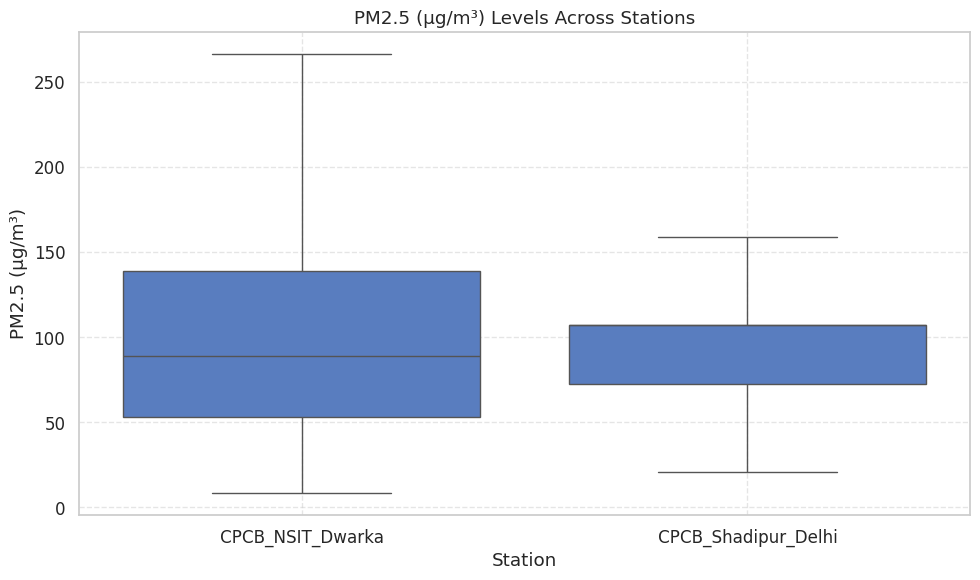

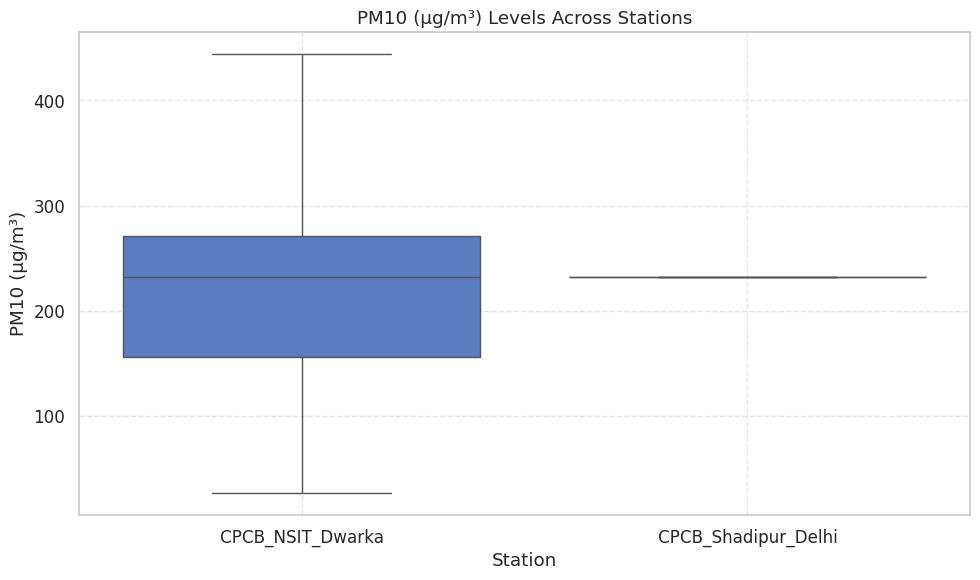

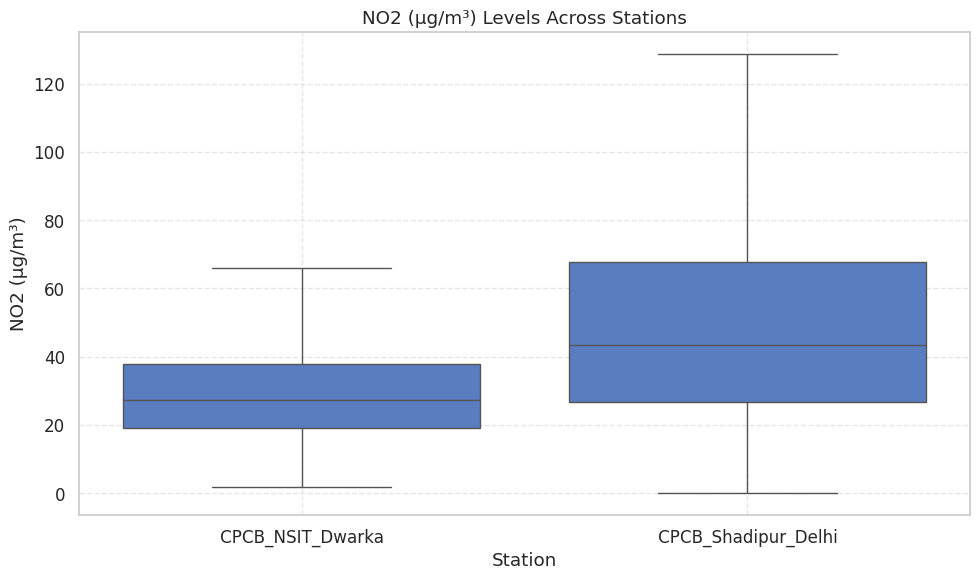

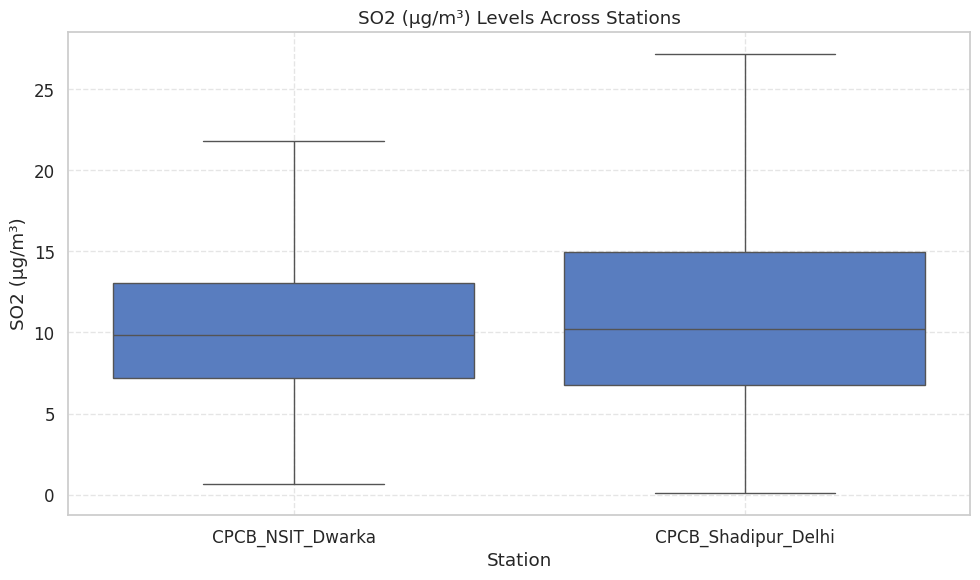

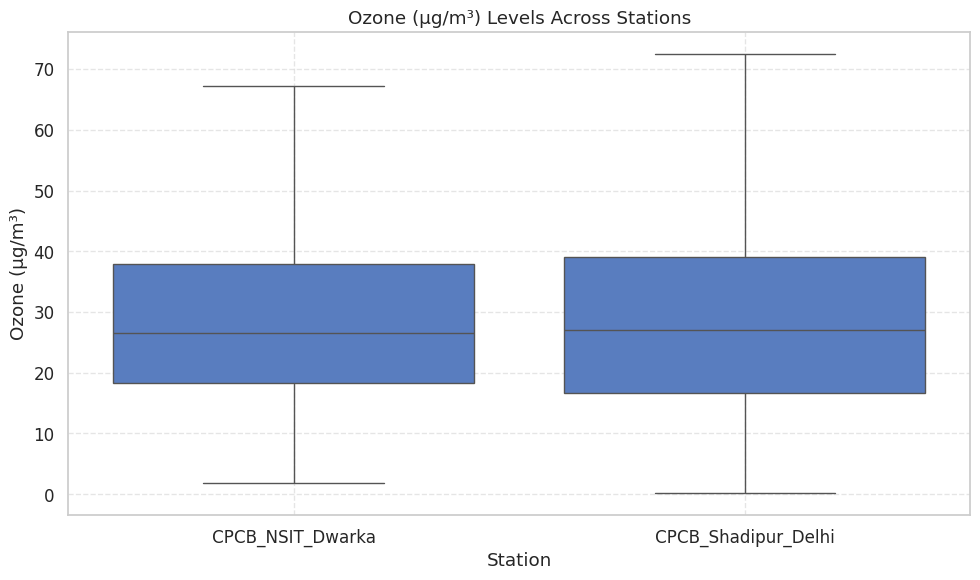

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pollutants = ["PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
              "SO2 (µg/m³)", "Ozone (µg/m³)"]

for pollutant in pollutants:

  plt.figure(figsize=(10, 6))
  sns.boxplot(data=merged_imputed_stations, x='station', y=pollutant, showfliers=False)
  plt.title(f'{pollutant} Levels Across Stations')
  plt.ylabel(pollutant)
  plt.xlabel("Station")
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  name = pollutant.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("µ", "u")
  plt.savefig(f"plots/{name}_boxplot.png", dpi=300, bbox_inches='tight')
  plt.show()
  plt.close()


# Seasonal BoxPlot

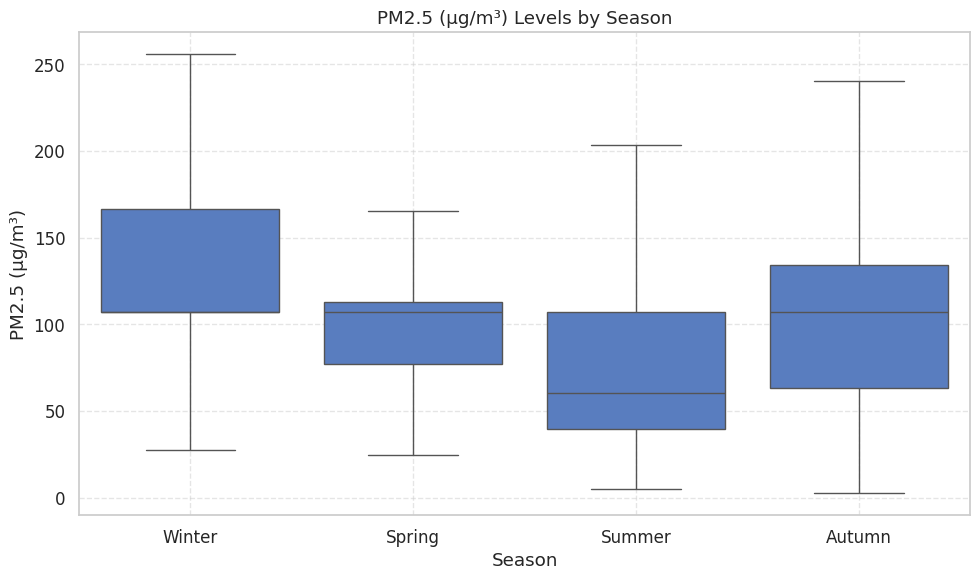

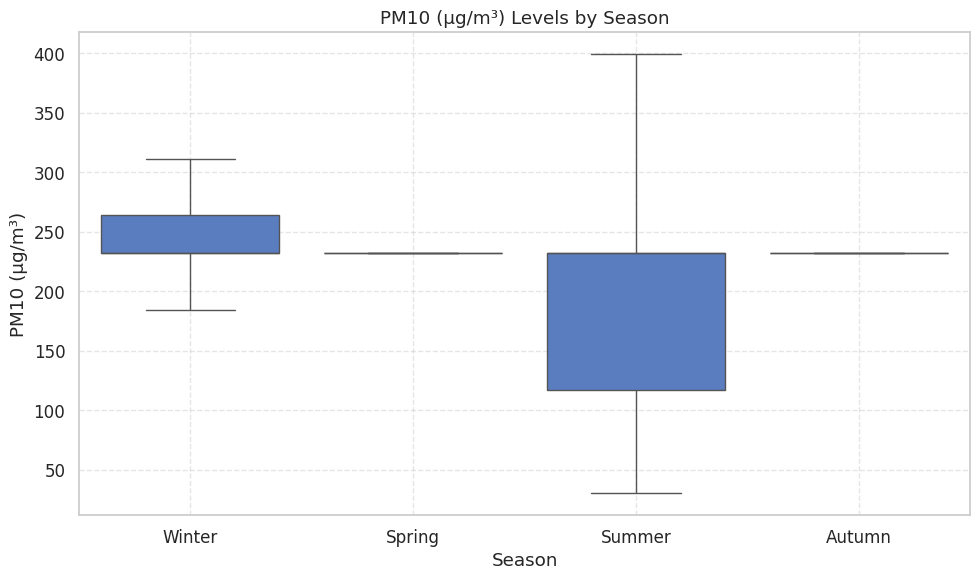

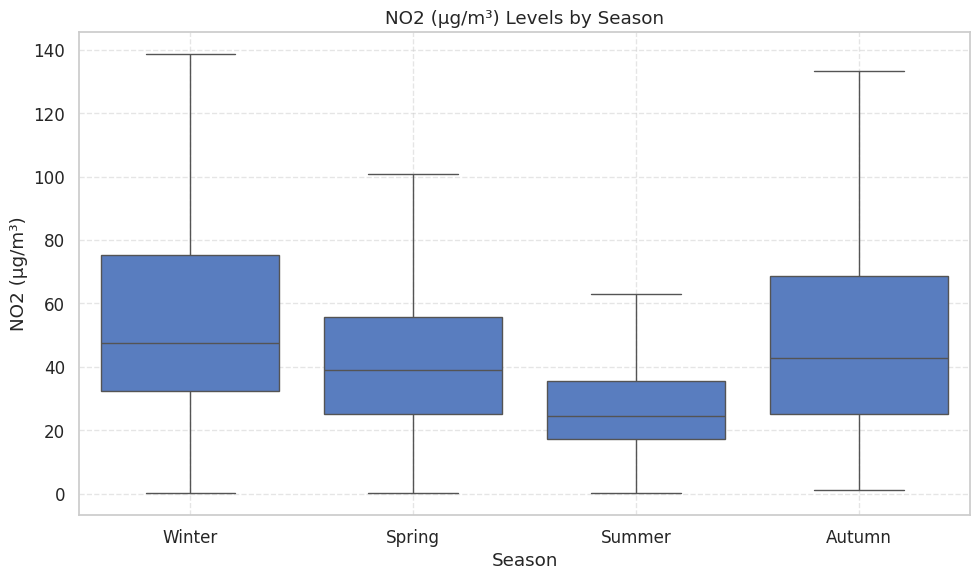

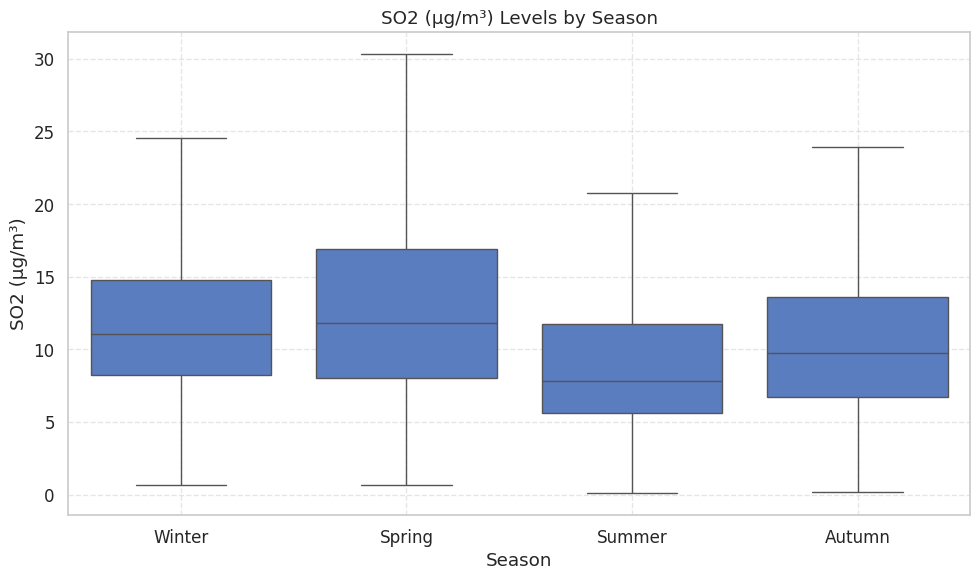

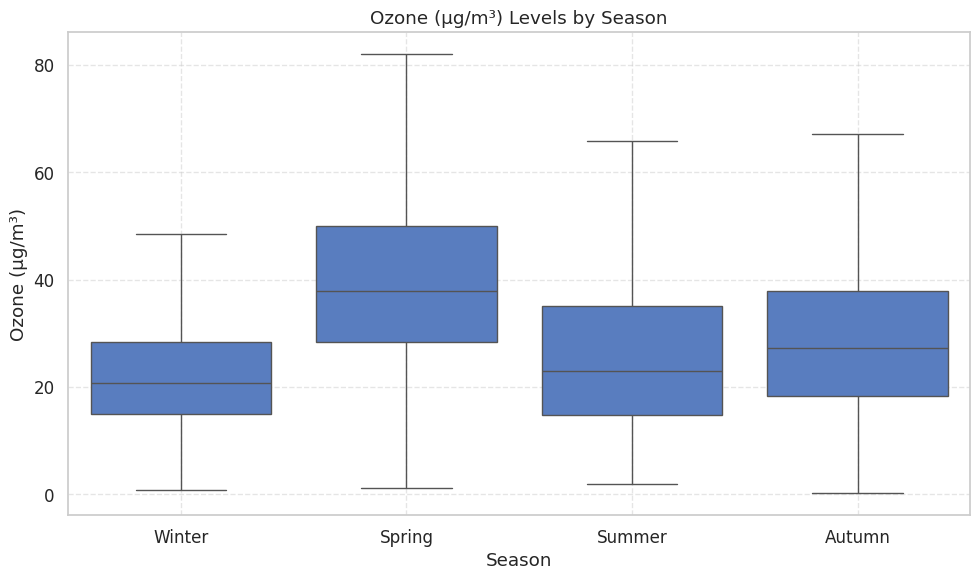

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

merged_imputed_stations['Timestamp'] = pd.to_datetime(merged_imputed_stations['Timestamp'])

# Function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

merged_imputed_stations['season'] = merged_imputed_stations['Timestamp'].dt.month.apply(month_to_season)

pollutants = ["PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
              "SO2 (µg/m³)", "Ozone (µg/m³)"]

for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_imputed_stations, x='season', y=pollutant, order=['Winter', 'Spring', 'Summer', 'Autumn'], showfliers=False)
    plt.title(f'{pollutant} Levels by Season')
    plt.ylabel(pollutant)
    plt.xlabel("Season")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    name = pollutant.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("µ", "u")
    plt.savefig(f"plots/{name}_seasonal_boxplot.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


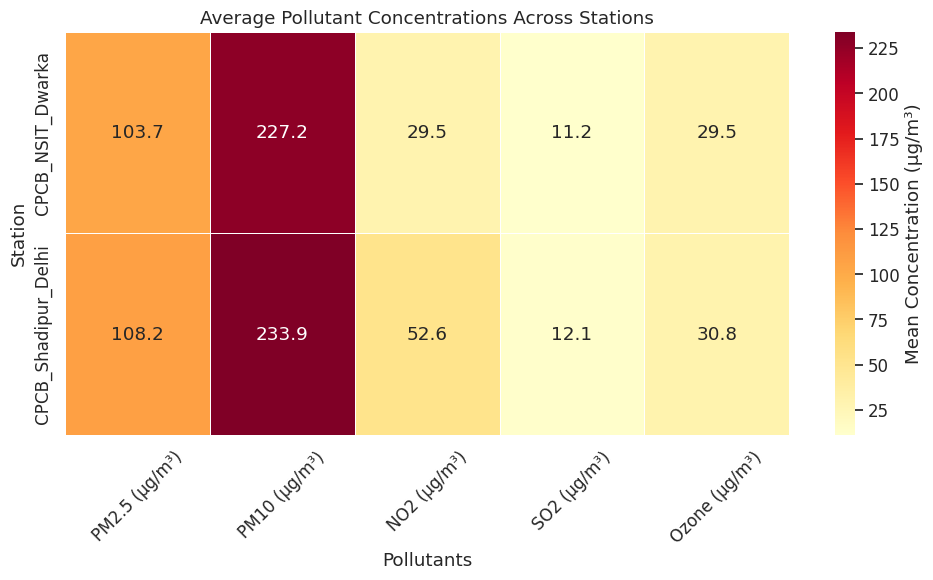

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pollutants = ["PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
              "SO2 (µg/m³)", "Ozone (µg/m³)"]

heatmap_data = merged_imputed_stations.groupby('station')[pollutants].mean(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Mean Concentration (µg/m³)'})
plt.title("Average Pollutant Concentrations Across Stations")
plt.xlabel("Pollutants")
plt.ylabel("Station")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"plots/Avg_pollutant_across_station.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

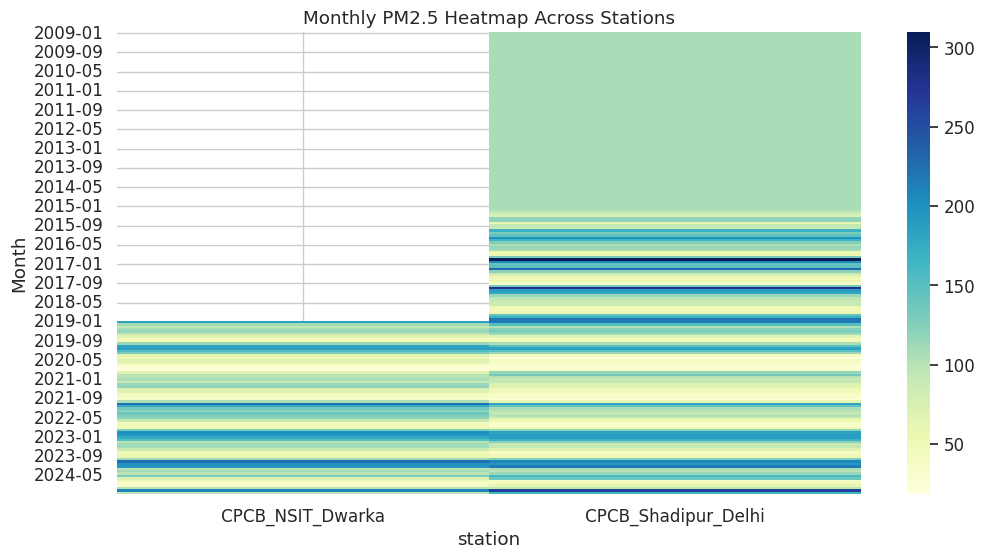

In [48]:
merged_imputed_stations['Month'] = merged_imputed_stations['Timestamp'].dt.to_period('M')
merged_imputed_stations_monthly_avg = merged_imputed_stations.groupby(['Month', 'station'])[pollutants].mean().reset_index()

# Example for PM2.5
pm25_pivot = merged_imputed_stations_monthly_avg.pivot(index='Month', columns='station', values='PM2.5 (µg/m³)')
plt.figure(figsize=(12,6))
sns.heatmap(pm25_pivot, cmap='YlGnBu', annot=False)
plt.title('Monthly PM2.5 Heatmap Across Stations')
plt.savefig(f"plots/Monthly_heatmap_across_stations.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Correlations (Spearman + Pearson) between pollutants and meteorological variables

In [49]:
import pandas as pd

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

pollutants_aqi = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
              'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
              'Ozone (µg/m³)']

met_vars =  ["T2M", "RH2M", "PRECTOTCORR"]

df_sub = df[pollutants_aqi + met_vars].dropna()

# Pearson correlation
pearson_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="pearson")
pearson_matrix = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], axis=0, method="pearson")

# correlation
spearman_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="spearman")

results = {}
for pol in pollutants_aqi:
    for met in met_vars:
        pear = df_sub[[pol, met]].corr(method="pearson").iloc[0,1]
        spear = df_sub[[pol, met]].corr(method="spearman").iloc[0,1]
        results[(pol, met)] = {"Pearson": pear, "Spearman": spear}

corr_df = pd.DataFrame(results).T.reset_index()
corr_df.columns = ["Pollutant/AQI", "Meteorological Variable", "Pearson", "Spearman"]

print(corr_df)


    Pollutant/AQI Meteorological Variable   Pearson  Spearman
0   PM2.5 (µg/m³)                     T2M -0.435989 -0.418264
1   PM2.5 (µg/m³)                    RH2M -0.247892 -0.371372
2   PM2.5 (µg/m³)             PRECTOTCORR -0.284767 -0.601952
3    PM10 (µg/m³)                     T2M -0.331257 -0.326816
4    PM10 (µg/m³)                    RH2M -0.375156 -0.421490
5    PM10 (µg/m³)             PRECTOTCORR -0.335124 -0.587913
6      NO (µg/m³)                     T2M -0.370561 -0.393888
7      NO (µg/m³)                    RH2M -0.062108 -0.032755
8      NO (µg/m³)             PRECTOTCORR -0.097122 -0.295381
9     NO2 (µg/m³)                     T2M -0.271505 -0.295213
10    NO2 (µg/m³)                    RH2M -0.218076 -0.258084
11    NO2 (µg/m³)             PRECTOTCORR -0.164368 -0.348410
12      NOx (ppb)                     T2M -0.372910 -0.397855
13      NOx (ppb)                    RH2M -0.150917 -0.176117
14      NOx (ppb)             PRECTOTCORR -0.142730 -0.369279
15    NH

/tmp/ipython-input-1970936278.py:18: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  spearman_corr = df_sub[pollutants_aqi].corrwith(df_sub[met_vars], method="spearman")


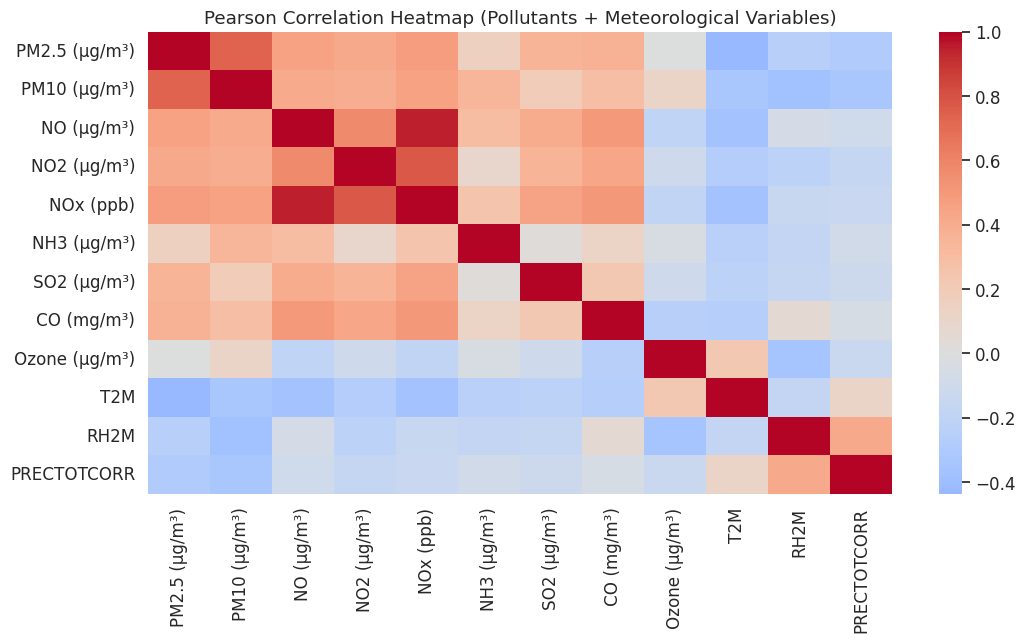

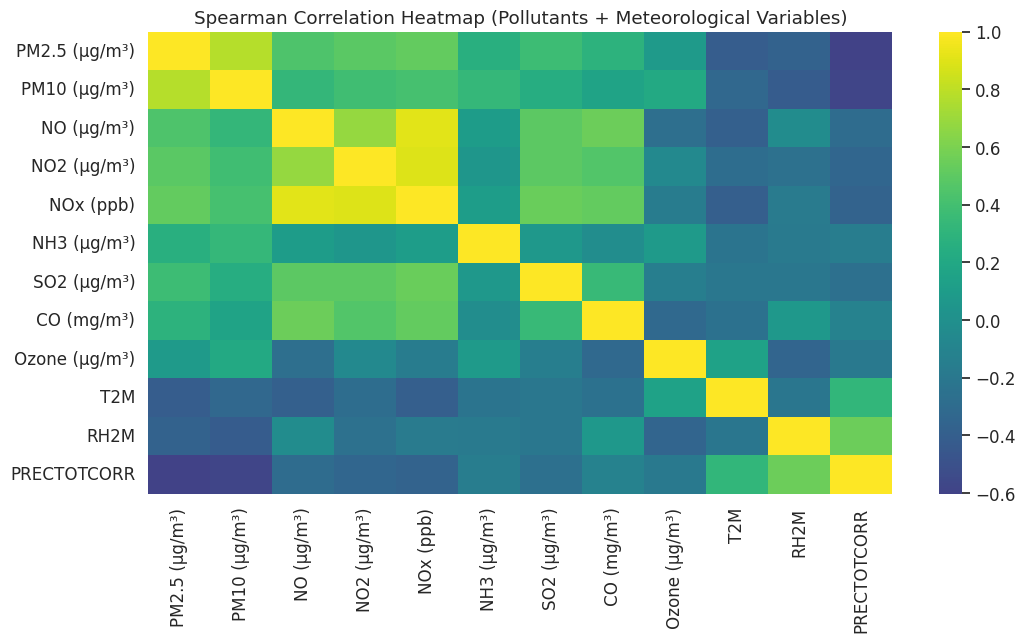

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Heatmap visualization
plt.figure(figsize=(12,6))
sns.heatmap(df_sub.corr(method="pearson"), annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Heatmap (Pollutants + Meteorological Variables)")

plt.savefig(f"plots/Pearson Correlation Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12,6))
sns.heatmap(df_sub.corr(method="spearman"), annot=False, cmap="viridis", center=0)
plt.title("Spearman Correlation Heatmap (Pollutants + Meteorological Variables)")

plt.savefig(f"plots/Spearman Correlation Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Linear Regression

In [51]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

pollutants = [
    "PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
    "SO2 (µg/m³)", "Ozone (µg/m³)"
]

features = ["T2M", "RH2M", "PRECTOTCORR", "WS (m/s)"]

for pollutant in pollutants:
    print(f"***********    POLLUTANT: {pollutant}    *************\n")

    existing_cols = [col for col in [pollutant] + features if col in df.columns]

    if pollutant in existing_cols and all(f in existing_cols for f in features):
        df_model = df[existing_cols].dropna()

        X = df_model[features]
        y = df_model[pollutant]

        # OLS Regression (statsmodels)
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        print(model.summary())

        # Linear Regression
        lr = LinearRegression()
        lr.fit(X, y)
        y_pred = lr.predict(X)

        mse = mean_squared_error(y, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y, y_pred)

        print("Learn Regression Results:")
        print(f"Intercept: {lr.intercept_:.4f}")
        print(f"Coefficients:")
        for f, c in zip(features, lr.coef_):
            print(f"  {f}: {c:.4f}")
        print(f"R² Score: {r2:.3f}")
        print(f"RMSE: {rmse:.3f}\n")

        # Feature Importance ---
        coef_dict = dict(zip(features, lr.coef_))
        importance = {k: abs(v) for k, v in coef_dict.items()}
        sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

        print("Feature Importance (based on absolute coefficient values):")
        for feat, imp in sorted_importance.items():
            print(f"{feat}: {imp:.4f}")
        print("\n" + "="*80 + "\n")

    else:
        print(f"Error: '{pollutant}' or some features {features} not found in DataFrame.\n")


***********    POLLUTANT: PM2.5 (µg/m³)    *************

                            OLS Regression Results                            
Dep. Variable:          PM2.5 (µg/m³)   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     312.2
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          3.15e-217
Time:                        09:00:03   Log-Likelihood:                -13180.
No. Observations:                2454   AIC:                         2.637e+04
Df Residuals:                    2449   BIC:                         2.640e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

# ANN

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

target = "Ozone (µg/m³)"
# target = "PM2.5 (µg/m³)"

features = ["T2M", "RH2M", "PRECTOTCORR", "WS (m/s)"]

print("Available columns:", df.columns.tolist())
print("Using target:", target)
print("Using features:", features)

df_model = df[[target] + features].dropna()

X = df_model[features].values
y = df_model[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Build ANN ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Train ---
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=16, verbose=1)

print()
# --- Evaluate ---
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")


Available columns: ['Date', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)', 'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)', 'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'Location', 'YEAR', 'DOY', 'RH2M', 'T2M', 'PRECTOTCORR', 'PM2.5 (µg/m³)_missing', 'PM10 (µg/m³)_missing', 'NO (µg/m³)_missing', 'NO2 (µg/m³)_missing', 'NOx (ppb)_missing', 'NH3 (µg/m³)_missing', 'SO2 (µg/m³)_missing', 'CO (mg/m³)_missing', 'Ozone (µg/m³)_missing', 'Benzene (µg/m³)_missing', 'Toluene (µg/m³)_missing', 'Xylene (µg/m³)_missing', 'O Xylene (µg/m³)_missing', 'Eth-Benzene (µg/m³)_missing', 'MP-Xylene (µg/m³)_missing', 'AT (°C)_missing', 'RH (%)_missing', 'WS (m/s)_missing', 'WD (deg)_missing', 'RF (mm)_missing', 'TOT-RF (mm)_missing', 'SR (W/mt2)_missing', 'BP (mmHg)_missing', 'VWS (m/s)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 875.7297 - mae: 25.9820 - val_loss: 437.0287 - val_mae: 15.4587
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 283.5255 - mae: 12.0743 - val_loss: 240.4127 - val_mae: 12.1152
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 192.2178 - mae: 10.5349 - val_loss: 223.4652 - val_mae: 11.6037
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 173.8827 - mae: 10.0697 - val_loss: 213.1253 - val_mae: 11.2237
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173.1237 - mae: 9.9333 - val_loss: 205.4360 - val_mae: 11.1108
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 172.4862 - mae: 9.8436 - val_loss: 201.3363 - val_mae: 10.8962
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173.8823 - mae: 9.8367 - val_loss: 198.2471 - val_mae: 10.7931
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 164.5055 - mae: 9.7220 - val_loss: 195.1062 - val_mae: 10.7401
Epoch 9/50
123/123 ━━━━

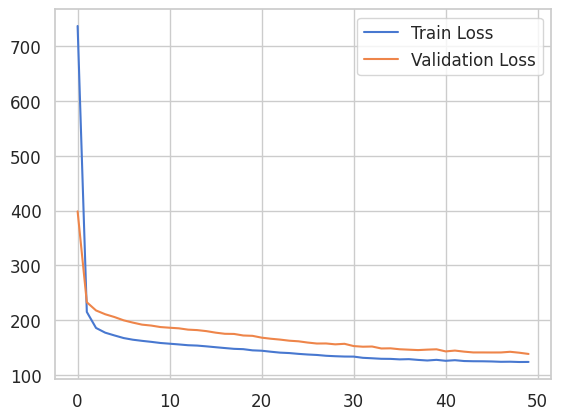

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


# Quantify meteorological influence

In [56]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.read_csv("Merged_CPCB_NASA_Dwarka_Imputed.csv")

pollutants = [
    "PM2.5 (µg/m³)", "PM10 (µg/m³)", "NO2 (µg/m³)",
    "SO2 (µg/m³)", "CO (mg/m³)", "Ozone (µg/m³)"
]
met_features = ["T2M", "RH2M", "PRECTOTCORR", "WS (m/s)"]

results = {}

for pollutant in pollutants:
    if pollutant in df.columns:
        df_model = df[[pollutant] + met_features].dropna()
        if df_model.empty:
            print(f"No data for {pollutant}, skipping.")
            continue

        X = df_model[met_features]
        y = df_model[pollutant]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        results[pollutant] = round(r2 * 100, 2)

print("Meteorological Influence (% Variance Explained):")
for pollutant, var_exp in results.items():
    print(f"{pollutant}: {var_exp}%")


Meteorological Influence (% Variance Explained):
PM2.5 (µg/m³): 33.86%
PM10 (µg/m³): 32.48%
NO2 (µg/m³): 28.2%
SO2 (µg/m³): 10.32%
CO (mg/m³): 22.07%
Ozone (µg/m³): 17.29%
